## CLASSIFICATION MODEL ---> PREDICTION OF BOOKING CANCELATION OR NOT

In [1]:
#Loading basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Nice plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("darkgrid")
palette=sns.color_palette("BuPu", n_colors=30)
palette.reverse()

#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#Several outputs in the same code cell
from IPython.core.interactiveshell import InteractiveShell #Para mostrar diversos outputs en una misma celda.
InteractiveShell.ast_node_interactivity = "all"

#Ignore annoying warning (from sklearn and seaborn)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

#Setting a seed for random steps
np.random.seed(0) 

### INSERT DATA

In [2]:
url_train="https://raw.githubusercontent.com/ArantxaData/ML_Classification_models_Booking-Cancelation/main/hotel_bookings.csv"

In [3]:
import requests
import io

download_train = requests.get(url_train).content
data=pd.read_csv(io.StringIO(download_train.decode('utf-8')))

In [4]:
#Our dataset has 32 features and 119390 observations.

data.head()
data.shape

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.000,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.000,NaN,0,Transient,75.000,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.000,NaN,0,Transient,98.000,0,1,Check-Out,7/3/2015


(119390, 32)

### MISSING VALUES

In [18]:
#There are four columns with missing values: 'Country', 'Agent' , 'Company' and 'Children'.

data.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

We already know that if 'agency' or 'company' is NaN, it means that the booking was made without their help, that is, by a private way. So in reality, these are not 'missing values', these data has no 'agent' and no 'company', so we will replace them with zero.

By other hand, there are only four missing values for 'children' variable, a very small proportion of total rows, so we could easily drop them. But instead, and with demonstrative purposes, let´s study the correlation between this feature and 'customer_type' feature.

In [59]:
#Most of the customer types make the booking without children, specially in transient-party customers.

data.groupby('customer_type')['children'].value_counts()

customer_type    children
Contract         0.000        3913
                 2.000          93
                 1.000          68
                 3.000           1
                 10.000          1
Group            0.000         550
                 1.000          17
                 2.000           9
                 3.000           1
Transient        0.000       81785
                 1.000        4433
                 2.000        3329
                 3.000          66
Transient-Party  0.000       24548
                 1.000         343
                 2.000         221
                 3.000           8
Name: children, dtype: int64

In [58]:
#The type of customers in rows with missing values for 'children' is 'Transient-Party'; so let´s replace those
#missing values with zero.

data[data['children'].isna()]['customer_type']

40600    Transient-Party
40667    Transient-Party
40679    Transient-Party
41160    Transient-Party
Name: customer_type, dtype: object

Now, let´s take a look to 'country' feature. It seems that in most cases when the booking has been made without an agent or company, the user has not insert the country field.

In [87]:
temp=data[data['country'].isna()][['agent','company','country']]
temp

,agent,company,country
30,0.000,0.000,NaN
4127,0.000,383.000,NaN
7092,0.000,204.000,NaN
7860,0.000,0.000,NaN
8779,0.000,457.000,NaN
...,...,...,...
65908,0.000,279.000,NaN
65909,0.000,279.000,NaN
65910,0.000,279.000,NaN
80830,37.000,0.000,NaN


In [88]:
temp['agent'].value_counts().sort_values(ascending=False)

0.000      334
240.000     51
250.000     15
12.000      14
96.000      12
314.000      7
6.000        7
94.000       6
146.000      4
468.000      3
196.000      3
241.000      3
184.000      3
201.000      3
171.000      2
327.000      2
177.000      2
142.000      1
15.000       1
105.000      1
181.000      1
446.000      1
242.000      1
5.000        1
9.000        1
78.000       1
330.000      1
154.000      1
385.000      1
339.000      1
139.000      1
175.000      1
37.000       1
14.000       1
Name: agent, dtype: int64

For this particular case, as there are many options for 'country' values and the proportion of missing values in the column is only the 0.4% of total, we will drop this rows.

In [4]:
#Sumarizing for missing values: Replaced with zero for all features with missing values except values in'country' that
#will be dropped.

data['agent']=data['agent'].fillna(0)
data['company']=data['company'].fillna(0)
data['children']=data['children'].fillna(0)
data=data.dropna(axis=0)
data.shape

(118902, 32)

### CHECKING FOR ERRORS IN DATASET

#### INCONSISTENCIES

It seems there are some inconsistencies in our dataset. For example, there are 170 bookings without any user as adult, children or baby.

In [5]:
errors=data[(data['adults']==0) & (data['children']==0) & (data['babies']==0)]
errors.shape

(170, 32)

In [6]:
#Dropping the above erroneus rows

data=data.drop(errors.index, axis=0)
data.shape

(118732, 32)

Also, there are bookings with zero nights in weekend and zero nights in week. For these cases, the 'reservation status date' is the same that the arrival date and the 'reservation status' is 'Check Out'. These are cases when people leave the same day that they arrive, perhaps a group meeting.

#### INCORRECT TYPE OF VARIABLE

In [18]:
#Checking the type of variables:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118732 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118732 non-null  object 
 1   is_canceled                     118732 non-null  int64  
 2   lead_time                       118732 non-null  int64  
 3   arrival_date_year               118732 non-null  int64  
 4   arrival_date_month              118732 non-null  object 
 5   arrival_date_week_number        118732 non-null  int64  
 6   arrival_date_day_of_month       118732 non-null  int64  
 7   stays_in_weekend_nights         118732 non-null  int64  
 8   stays_in_week_nights            118732 non-null  int64  
 9   adults                          118732 non-null  int64  
 10  children                        118732 non-null  float64
 11  babies                          118732 non-null  int64  
 12  meal            

In [7]:
#Changing some feature types:

data['children']=data['children'].astype('int64')
data['agent']=data['agent'].astype('int64')
data['company']=data['company'].astype('int64')

### EDA: EXPLORATORY DATA ANALYSIS

Let´s make some questions about our data to have a deeper understanding.

1. Where do host come from? Let´s plot the main 25 countries with bookings. The main 5 countries are: Portugal, Great
Britain, France, Spain and Deutchland.

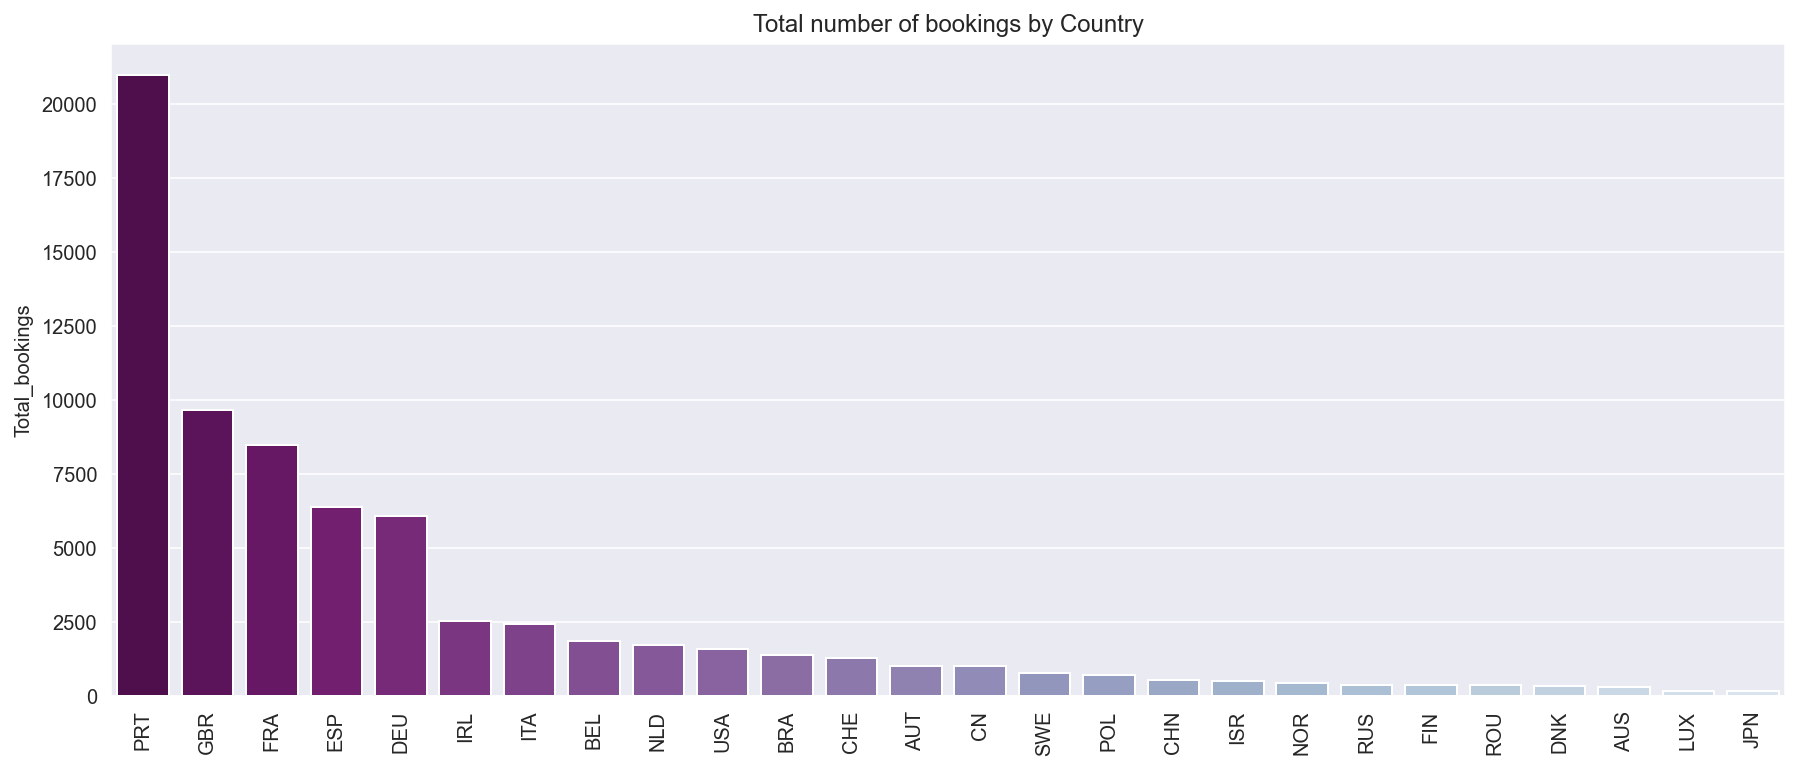

In [112]:
total_hosts=data[data['is_canceled']==0]['country'].value_counts()
temp=pd.DataFrame(total_hosts.sort_values(ascending=False)).iloc[:26]
temp.columns=['Total_bookings']

plt.subplots(figsize=(15,6))
plt.xticks(rotation='90')
plt.title('Total number of bookings by Country')
sns.barplot(x=temp.index,y=temp['Total_bookings'], palette=palette);

2. How much do guest pay for a room per night?

In [66]:
#There are only two hotels in dataset: City Hotel and Resort Hotel

data['hotel'].value_counts()

City Hotel      79147
Resort Hotel    39585
Name: hotel, dtype: int64

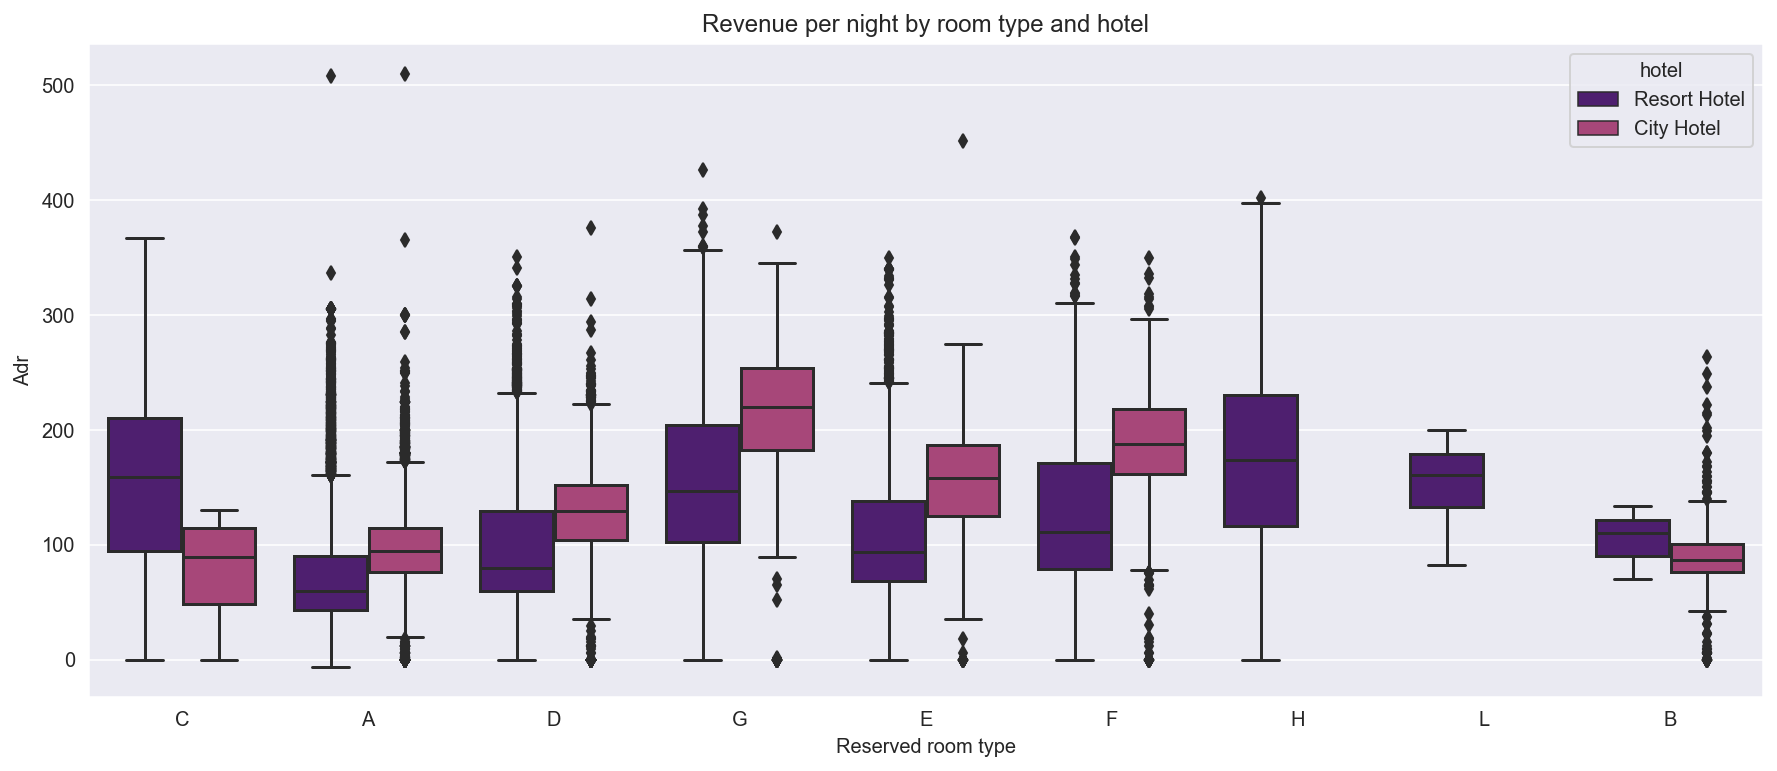

In [129]:
#Revenue per night by room type

temp=data[data['is_canceled']==0]

plt.subplots(figsize=(15,6))
sns.set_palette(sns.color_palette("magma", n_colors=3))
plt.title('Revenue per night by room type and hotel')
sns.boxplot(data=temp, x='reserved_room_type', y='adr', hue='hotel').set(xlabel='Reserved room type', ylabel='Adr');

It seems that there are many fluctuations in the price of a room for some types of rooms. There are many outliers, perhaps depending on the arrival date (specially month) the price is higher. Let´s check it.

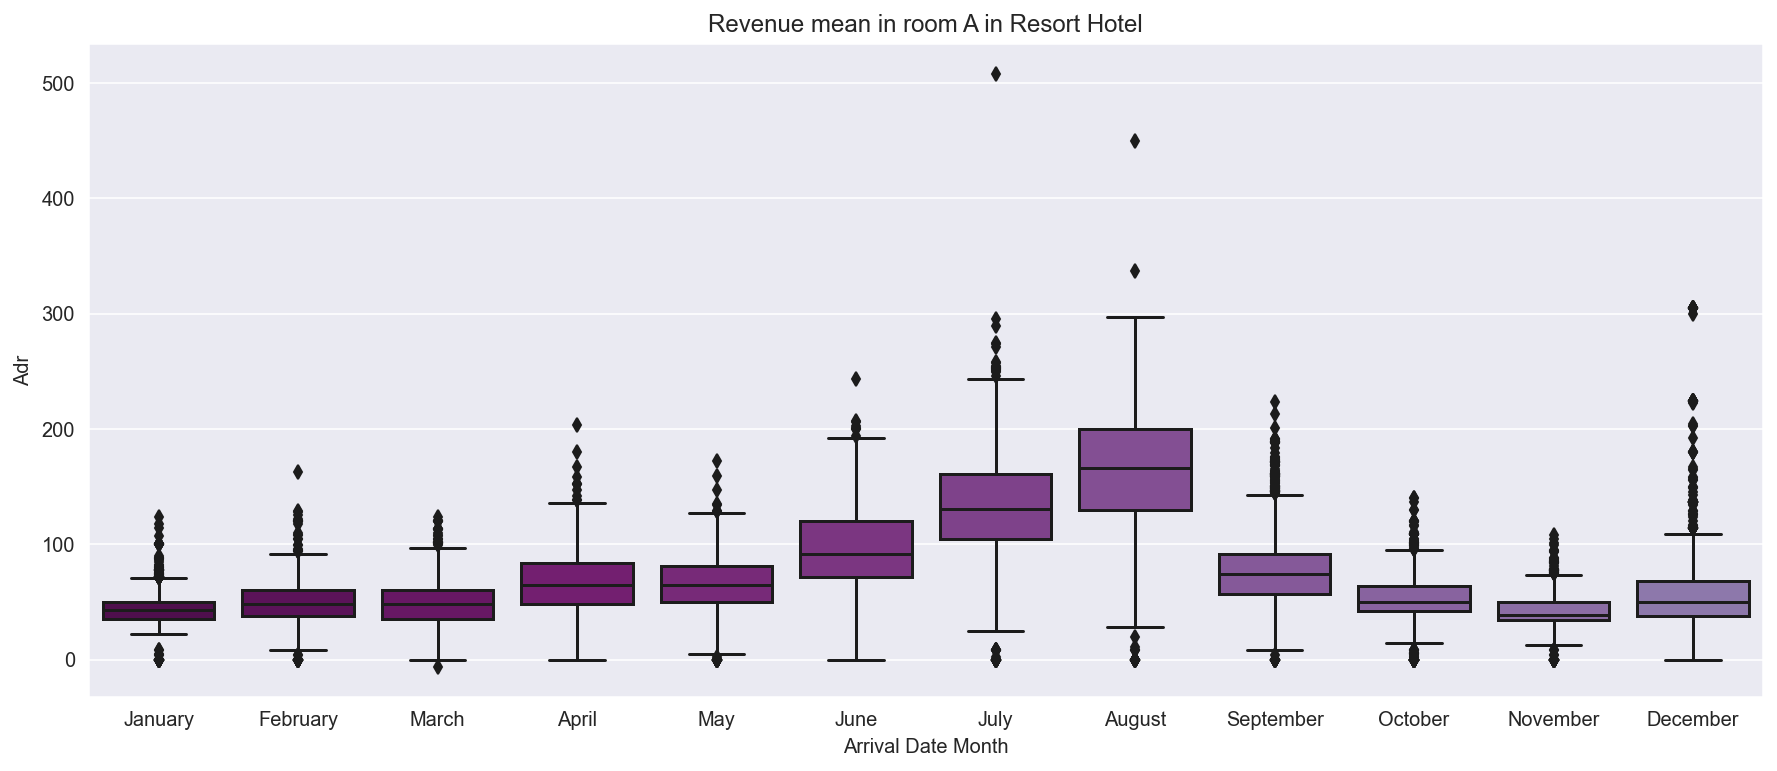

In [130]:
temp=data[(data['reserved_room_type']=='A') & (data['hotel']=='Resort Hotel')][['arrival_date_month','adr']]

plt.subplots(figsize=(15,6))
monthly=['January','February','March','April','May','June','July','August','September','October','November','December']
plt.title('Revenue mean in room A in Resort Hotel')

fig=sns.boxplot(temp['arrival_date_month'], temp['adr'], order=monthly, palette=palette)
fig.set(xlabel='Arrival Date Month', ylabel='Adr');

Yes, it seems that the price is higher when it is summer or eastern; for room type A in Resort Hotel. This room is one with most extreme outliers in dataset. Nevertheless, there are many outliers also in the rest of months.

Now, let´s see the variation in price over the year for both hotels.

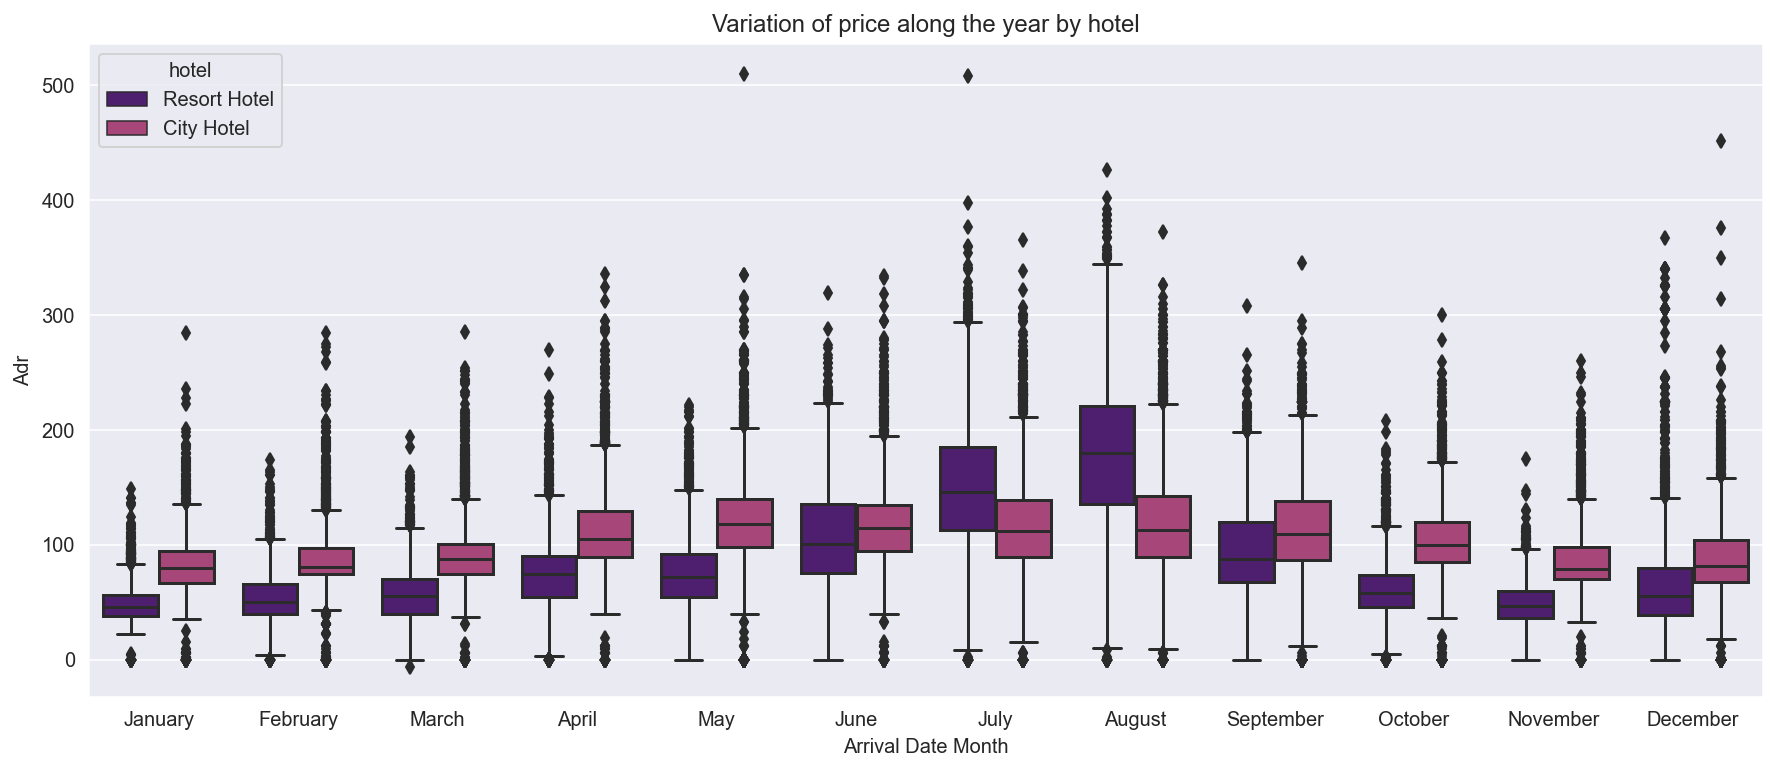

In [131]:
temp=data[data['is_canceled']==0]

plt.subplots(figsize=(15,6))
plt.title('Variation of price along the year by hotel')
fig=sns.boxplot(data=temp, x='arrival_date_month', y='adr', hue='hotel', order=monthly)
fig.set(xlabel='Arrival Date Month', ylabel='Adr');

The price in Resort Hotel fluctuates more than in City Hotel. Prices are higher during summer, but the are cheaper along the rest of months.

3. How much has been the total revenue by Hotel along the year?

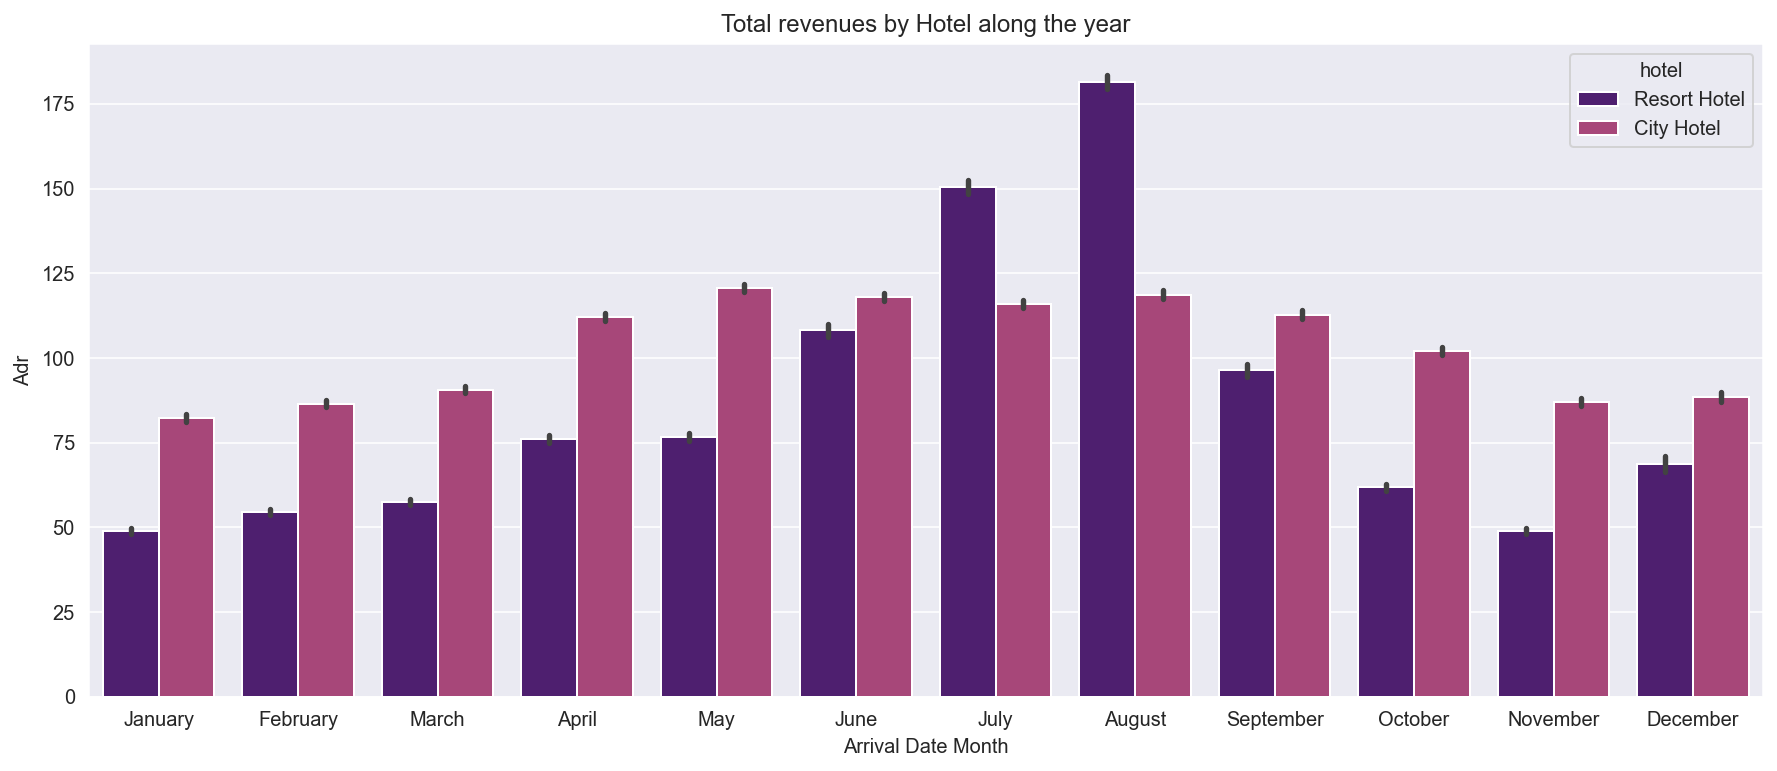

In [132]:
plt.subplots(figsize=(15,6))
plt.title('Total revenues by Hotel along the year')
fig=sns.barplot(data=temp, x='arrival_date_month',y='adr', hue='hotel', order=monthly)
fig.set(xlabel='Arrival Date Month', ylabel='Adr');

 4.In which month are there more customers? City hotel has clearly more demand.

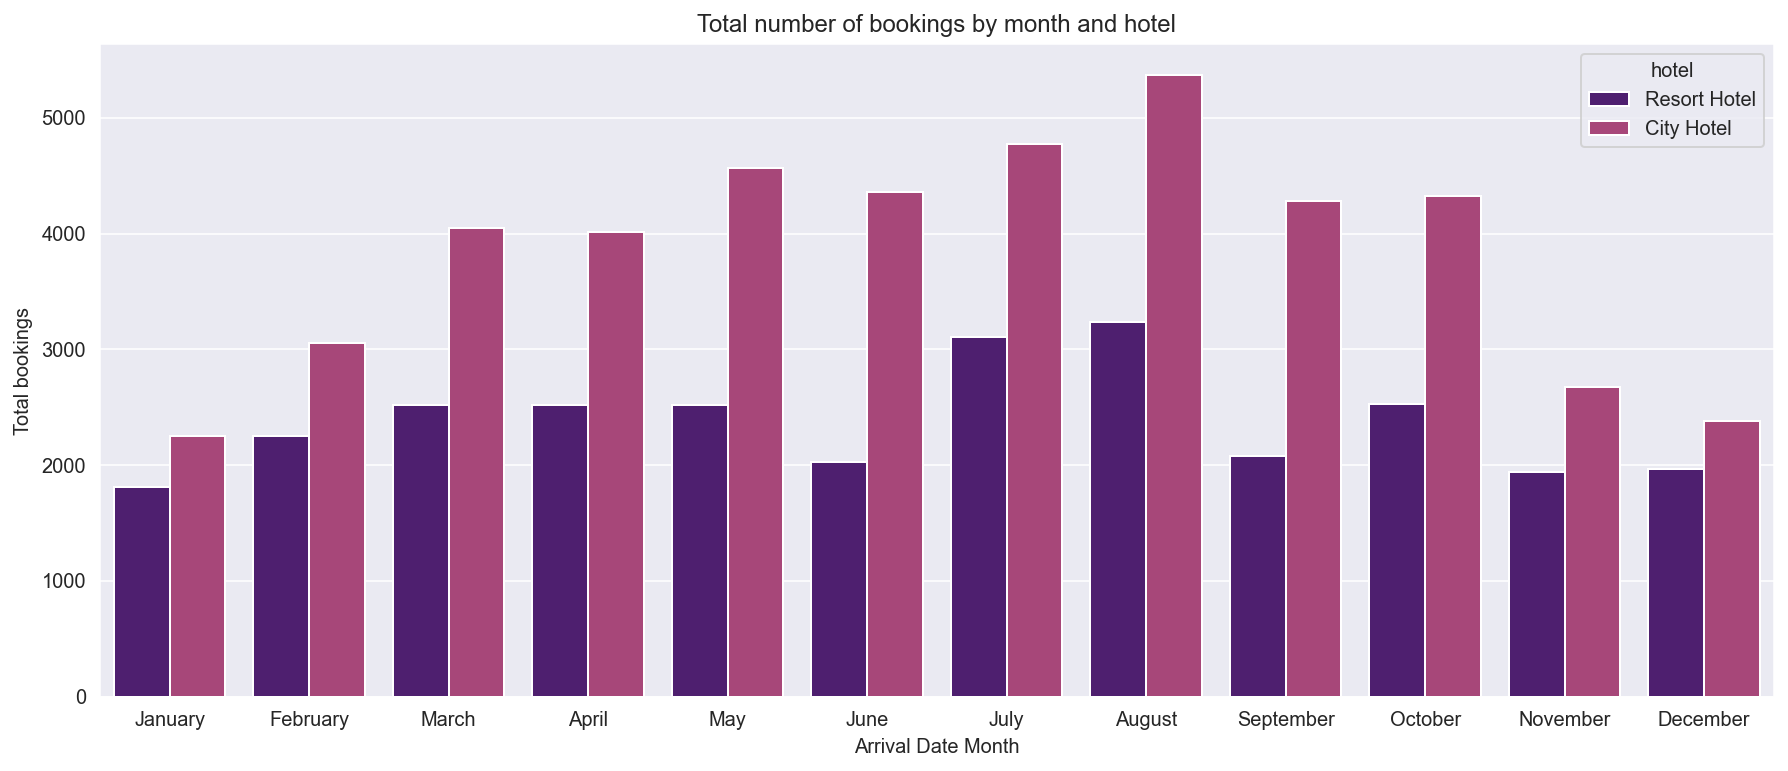

In [133]:
plt.subplots(figsize=(15,6))
plt.title('Total number of bookings by month and hotel')
fig=sns.countplot(data=temp, x='arrival_date_month', hue='hotel', order=monthly)
fig.set(xlabel='Arrival Date Month', ylabel='Total bookings');

5. Are there bookings with negative or null revenues?

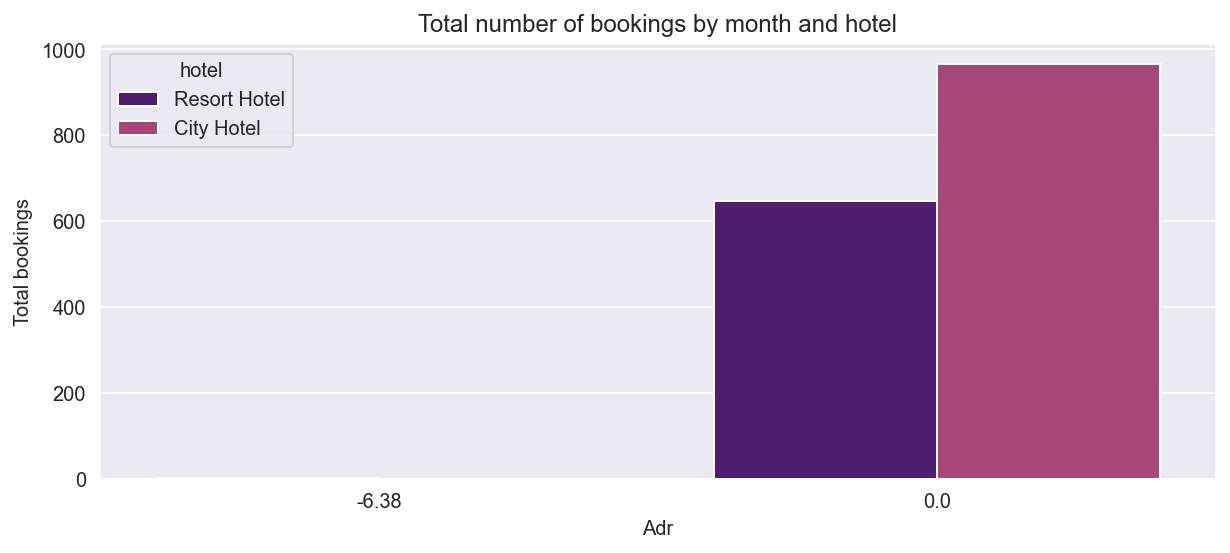

In [135]:
adr_=temp[temp['adr']<=0]['adr']

plt.subplots(figsize=(10,4))
plt.title('Total number of bookings by month and hotel')
fig=sns.countplot(data=temp, x=adr_, hue='hotel')
fig.set(xlabel='Adr', ylabel='Total bookings');

Well, we should take a look to the business information (if we would have it) to find some reasons why the revenue has been zero or even negative in those cases.

### CORRELATIONS 

Now explore the relationships between the features and the target. Before study any particular case, let´s see first the general correlation between target and features. We will use Chi2 and Mutual Information methods for that.

#### CHI2: Correlation between target and categorical features

In [16]:
import scipy.stats as stats

target=data['is_canceled']
temp=data
temp=temp.drop('is_canceled', axis=1)
nominal=temp.select_dtypes('object').columns

for col in nominal:
    contingency = pd.crosstab(temp[col], target).values
    val=stats.chi2_contingency(contingency)

    print('The p-value of variable {} with target is : {}'. format(col, val[1])) 

The p-value of variable hotel with target is : 0.0
The p-value of variable arrival_date_month with target is : 4.842680664797987e-112
The p-value of variable meal with target is : 9.134181208322299e-65
The p-value of variable country with target is : 0.0
The p-value of variable market_segment with target is : 0.0
The p-value of variable distribution_channel with target is : 0.0
The p-value of variable reserved_room_type with target is : 1.9475763816952416e-132
The p-value of variable assigned_room_type with target is : 0.0
The p-value of variable deposit_type with target is : 0.0
The p-value of variable customer_type with target is : 0.0


#### MUTUAL INFORMATION: Correlation between target and categorical/numerical features 

Mutual information measures the quantity that the entropy drops under the condition of target value. It is the same concept that it is applied by Decission Trees. It´s a value within a range from 0 to 1. The higher the value, the higher the connection between the feature and the target, because this means that the 'entropy drop' due to that feature is also higher.

In [40]:
#Variables need to be numeric with this method:

from sklearn.feature_selection import mutual_info_classif as MIC
import category_encoders as ce

nominal=temp.select_dtypes('object')

OrdEnc=ce.ordinal.OrdinalEncoder(return_df=True, cols=nominal)
temp=OrdEnc.fit_transform(temp) 

mic_score = MIC(temp,target)
dict_=dict(zip(temp.columns,mic_score))
sorted(dict_.items(), key=lambda x: x[1])

[('children', 0.0),
 ('arrival_date_day_of_month', 0.0004982484267459508),
 ('babies', 0.0009332749024582032),
 ('is_repeated_guest', 0.0013325774197168183),
 ('arrival_date_week_number', 0.0029911704934804106),
 ('stays_in_weekend_nights', 0.003721853278099818),
 ('arrival_date_year', 0.005131568855738955),
 ('arrival_date_month', 0.00532624425552175),
 ('meal', 0.007832286142121836),
 ('previous_bookings_not_canceled', 0.007899306359250735),
 ('stays_in_week_nights', 0.008097822309178104),
 ('reserved_room_type', 0.010390450890184422),
 ('company', 0.011334109094708333),
 ('adults', 0.014534488614530883),
 ('days_in_waiting_list', 0.016229071040041454),
 ('hotel', 0.017362971733780874),
 ('booking_changes', 0.018513566506557444),
 ('customer_type', 0.019632623572518604),
 ('assigned_room_type', 0.026083850209478676),
 ('distribution_channel', 0.026360014714708946),
 ('required_car_parking_spaces', 0.031038519943699328),
 ('total_of_special_requests', 0.038254670766400656),
 ('previou

There are correlations between features and our target. Let´s go deeper to see this with more detail with some plots.

In [43]:
data[['arrival_date_year','arrival_date_month','arrival_date_day_of_month','reservation_status_date','reservation_status']]

,arrival_date_year,arrival_date_month,arrival_date_day_of_month,reservation_status_date,reservation_status
0,2015,July,1,7/1/2015,Check-Out
1,2015,July,1,7/1/2015,Check-Out
2,2015,July,1,7/2/2015,Check-Out
3,2015,July,1,7/2/2015,Check-Out
4,2015,July,1,7/3/2015,Check-Out
...,...,...,...,...,...
119385,2017,August,30,9/6/2017,Check-Out
119386,2017,August,31,9/7/2017,Check-Out
119387,2017,August,31,9/7/2017,Check-Out
119388,2017,August,31,9/7/2017,Check-Out


The features 'reservation_status_date' and 'reservation_status' are highly correlated with target, but the information in this features is known after the event has taken place. If there has been a cancellation, then we update the information with a Cancelled status and update the 'status_date'. If there is no cancellation, then the fields are updated when the check-out takes place. So, we don´t know this information previosly to make a prediction, and also considering this information we can lead to Target Leakage, so we will drop them from the dataset.

#### DELETING 'DATA LEAKAGE' COLUMNS

We should avoid Data Leakage in our model. Data Leakage occurs when we have features highly correlated with target but in a not desirable way, that is, when these features 'have information of the future', or in other words, they are related with the final output of the target, so they are introducing information that we don´t usually know when we want to make a prediction. The accuracy of models with data leakage improves a lot, sometimes (as in this case) can reach even the perfect match with the real output (100% accuracy), but this is a signal of something going wrong. If we drop these columns we have a more real scenario, with a lower but more real accuracy.

In [8]:
data=data.drop(['reservation_status_date','reservation_status'], axis=1)

#### CORRELATION BETWEEN TARGET AND SOME FEATURES

DEPOSIT TYPE - CANCELLATIONS: There are more cancelations in bookings without deposit.

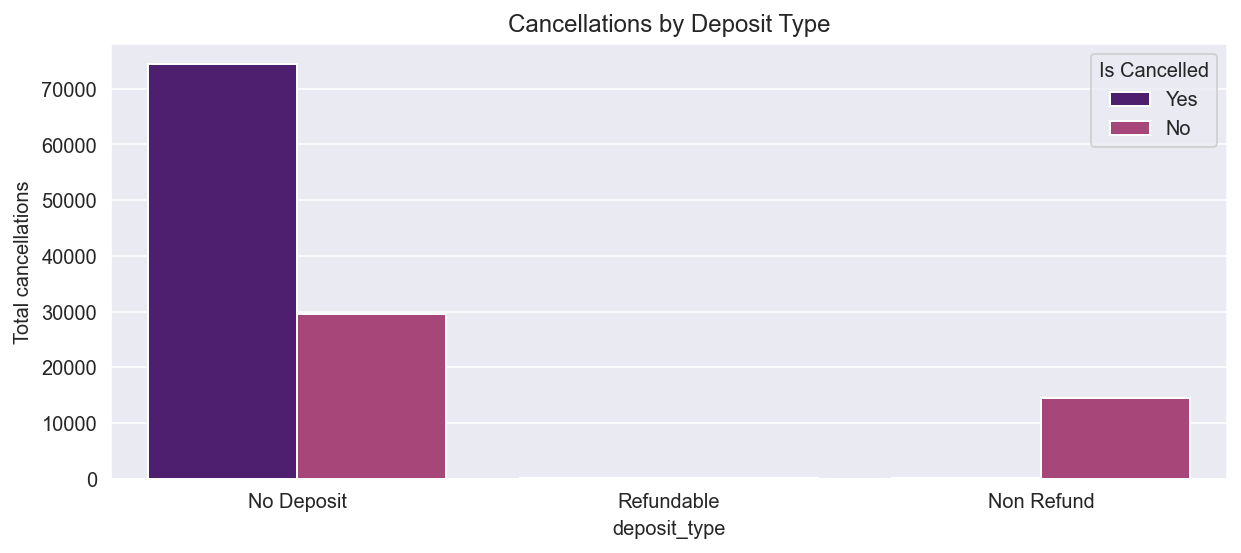

In [142]:
plt.subplots(figsize=(10,4))
plt.title('Cancellations by Deposit Type')
fig=sns.countplot(data['deposit_type'], hue=target)
fig.set(ylabel='Total cancellations')
plt.legend(['Yes','No'], title='Is Cancelled');

LEAD TIME - CANCELLATIONS: The higher the lead-time, the higher the probability of a booking to be cancelled.

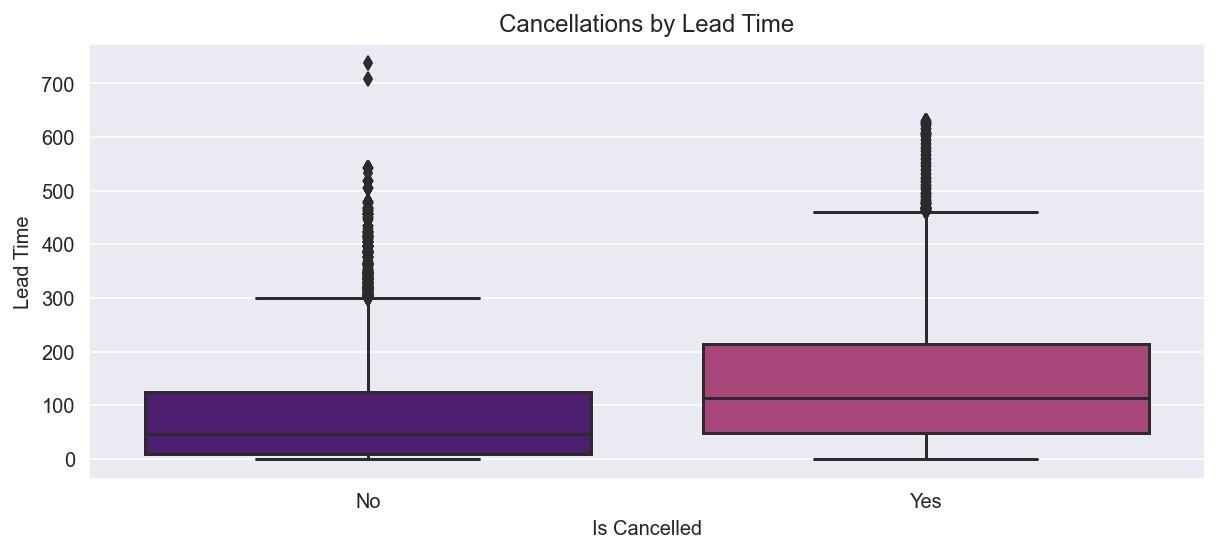

In [147]:
plt.subplots(figsize=(10,4))
plt.title('Cancellations by Lead Time')
fig=sns.boxplot(x=target, y=data['lead_time'])
fig.set(xlabel='Is Cancelled', ylabel='Lead Time')
fig.set_xticklabels(["No", "Yes"]);

ADR - CANCELLATIONS: Not a big influence.

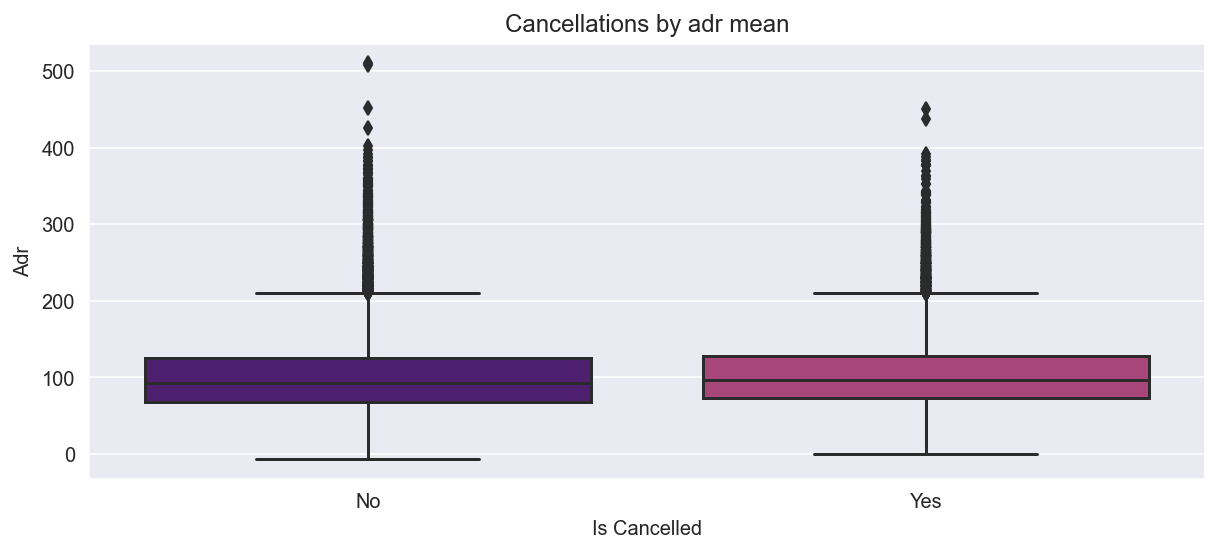

In [148]:
adr_index=data[data['adr']>5000].index
data=data.drop(adr_index, axis=0)
plt.subplots(figsize=(10,4))
plt.title('Cancellations by adr mean')
fig=sns.boxplot(x=target, y=data['adr'])
fig.set(xlabel='Is Cancelled', ylabel='Adr')
fig.set_xticklabels(["No", "Yes"]);

TOP 15 AGENTS WITH MORE CANCELLATIONS: Agent number '9' has 30% of the total cancellations.

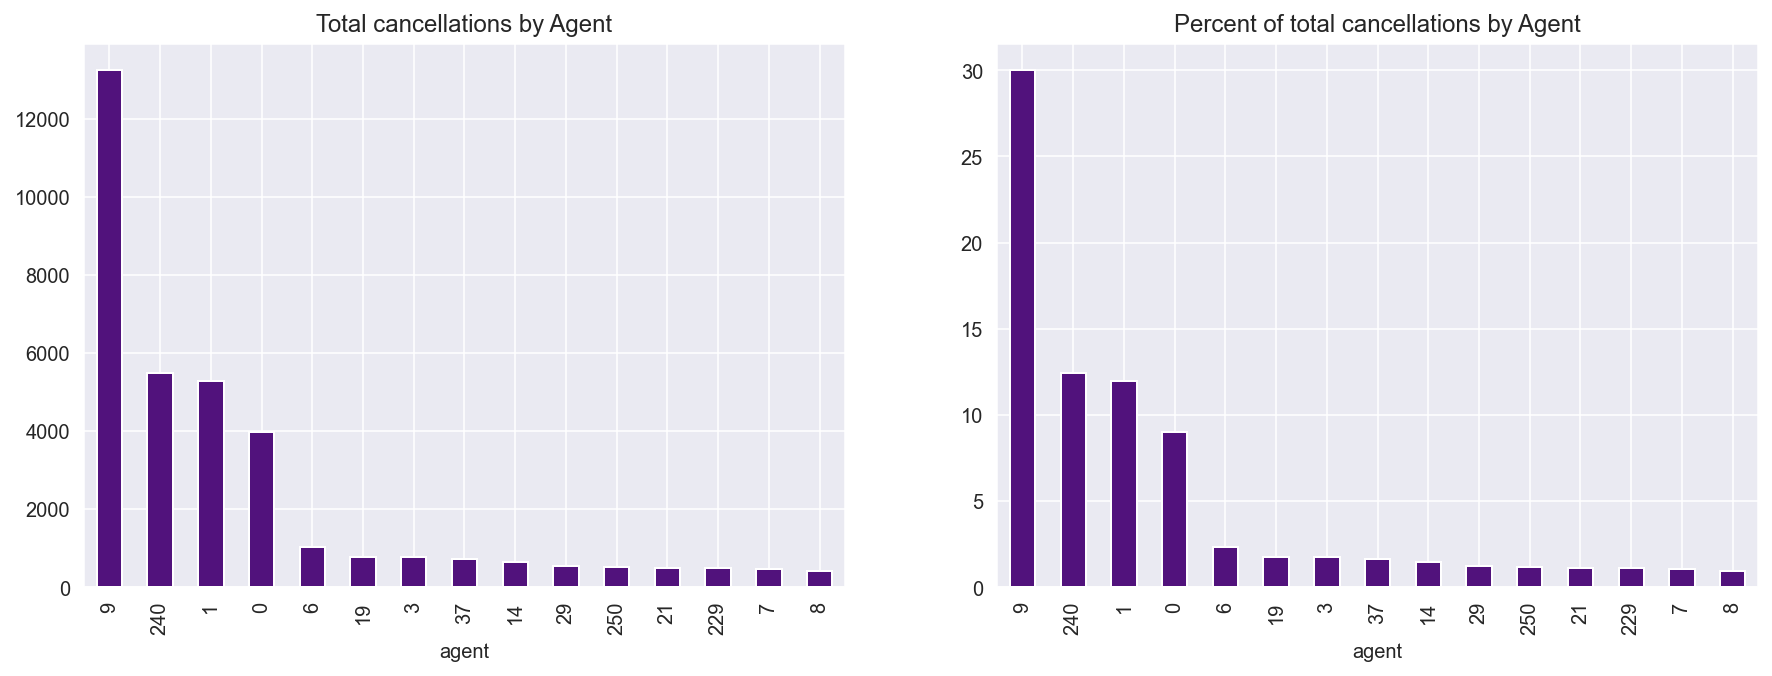

In [122]:
fig, axes= plt.subplots(1,2,figsize=(15,5))

temp=data[data['is_canceled']==1]
temp.groupby('agent')['is_canceled'].sum().sort_values(ascending=False).head(15).plot(kind='bar', ax=axes[0],
                                                                        title='Total cancellations by Agent')
temp=temp.groupby('agent')['is_canceled'].sum()/len(temp)*100
temp.sort_values(ascending=False).head(15).plot(kind='bar', ax=axes[1], title='Percent of total cancellations by Agent');

COUNTRY - CANCELLATIONS: Portugal has more than 60% of the total number of cancellations.

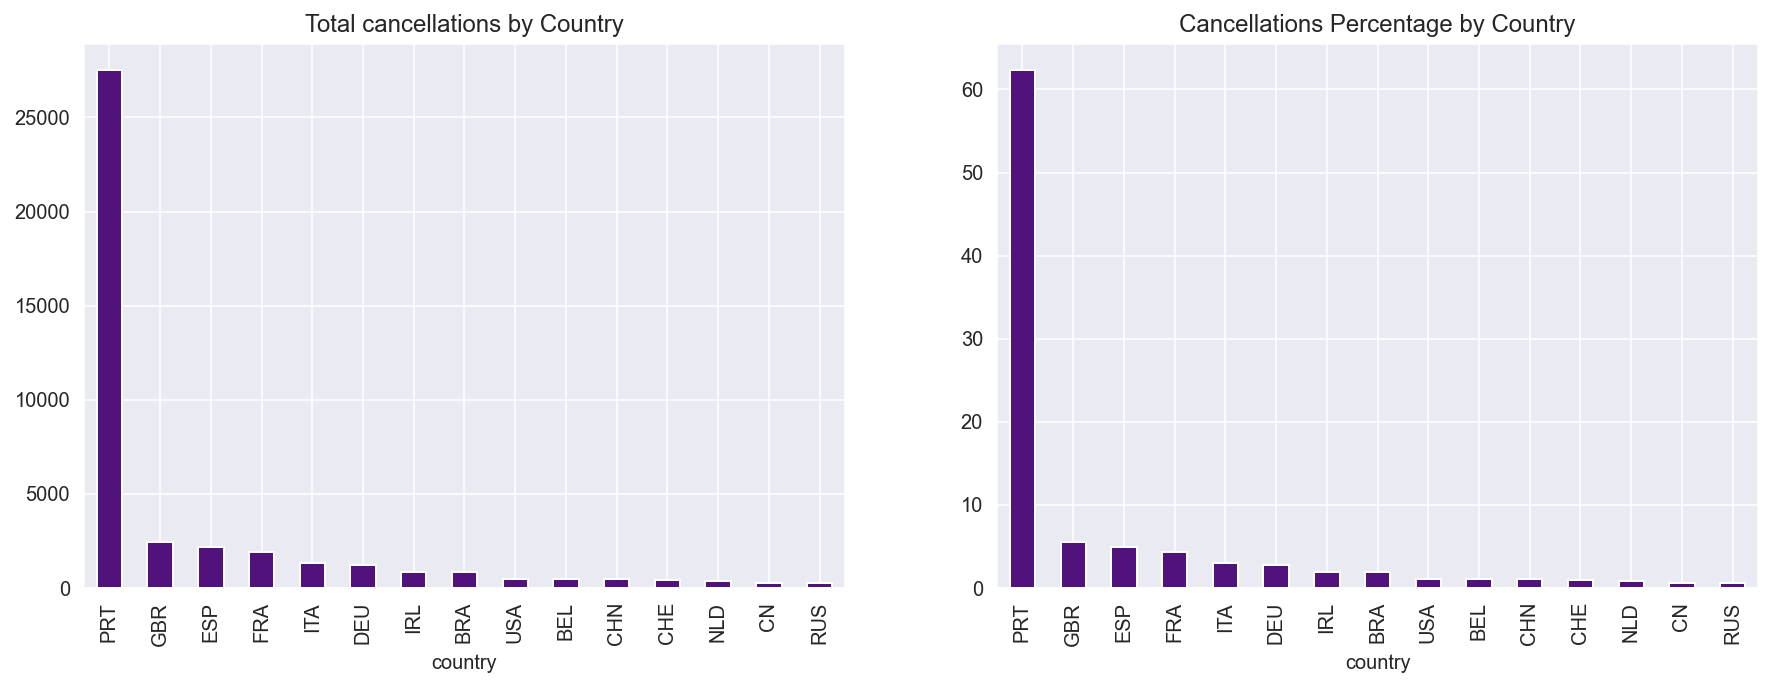

In [123]:
fig, axes= plt.subplots(1,2,figsize=(15,5))

temp=data[data['is_canceled']==1]
temp.groupby('country')['is_canceled'].sum().sort_values(ascending=False).head(15).plot(kind='bar', ax=axes[0],
                                                                        title='Total cancellations by Country')
temp=temp.groupby('country')['is_canceled'].sum()/len(temp)*100
temp.sort_values(ascending=False).head(15).plot(kind='bar', ax=axes[1], title='Cancellations Percentage by Country');

Let´s see the number of total bookings by Country: More than 50% of bookings in Portugal are cancelled.

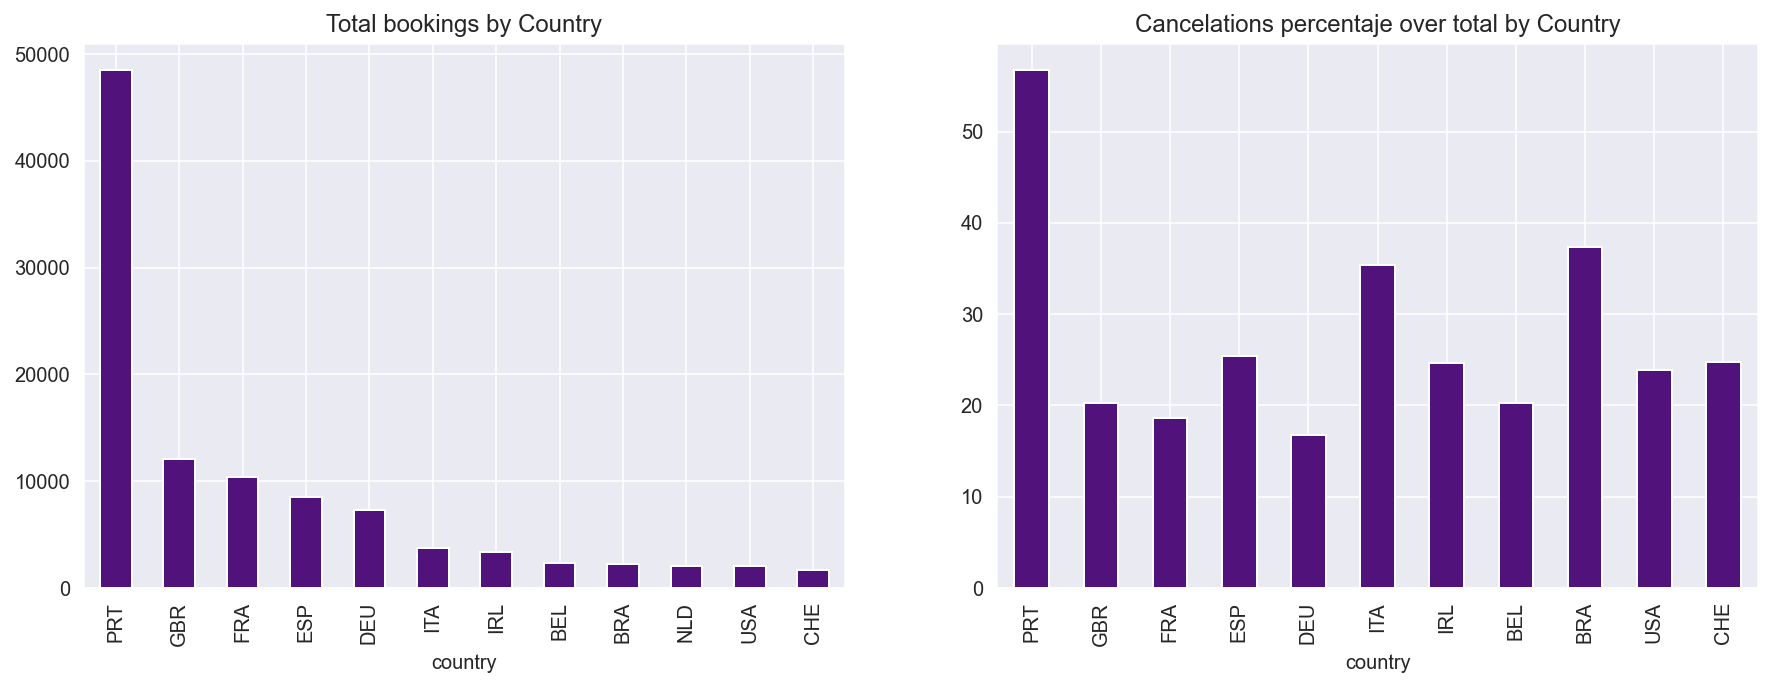

In [124]:
fig, axes= plt.subplots(1,2,figsize=(15,5))

data.groupby('country')['is_canceled'].count().sort_values(ascending=False).head(12).plot(kind='bar', ax=axes[0], 
                                                                        title='Total bookings by Country');

temp1=pd.DataFrame(data.groupby('country')['is_canceled'].count().sort_values(ascending=False).head(12))
temp=data[data['is_canceled']==1]
temp2=pd.DataFrame(temp.groupby('country')['is_canceled'].sum().sort_values(ascending=False).head(12))
temp3=temp1.join(temp2, lsuffix='_').dropna()
temp3['Perc_Cancelations']=(temp3['is_canceled']/temp3['is_canceled_'])*100
temp3['Perc_Cancelations'].plot(kind='bar', ax=axes[1], title='Cancelations percentaje over total by Country');

MARKET SEGMENT - CANCELLATIONS: Online method counts more bookings but also more cancellations.
Also, bookings for groups seems to have a high ratio of cancellations.

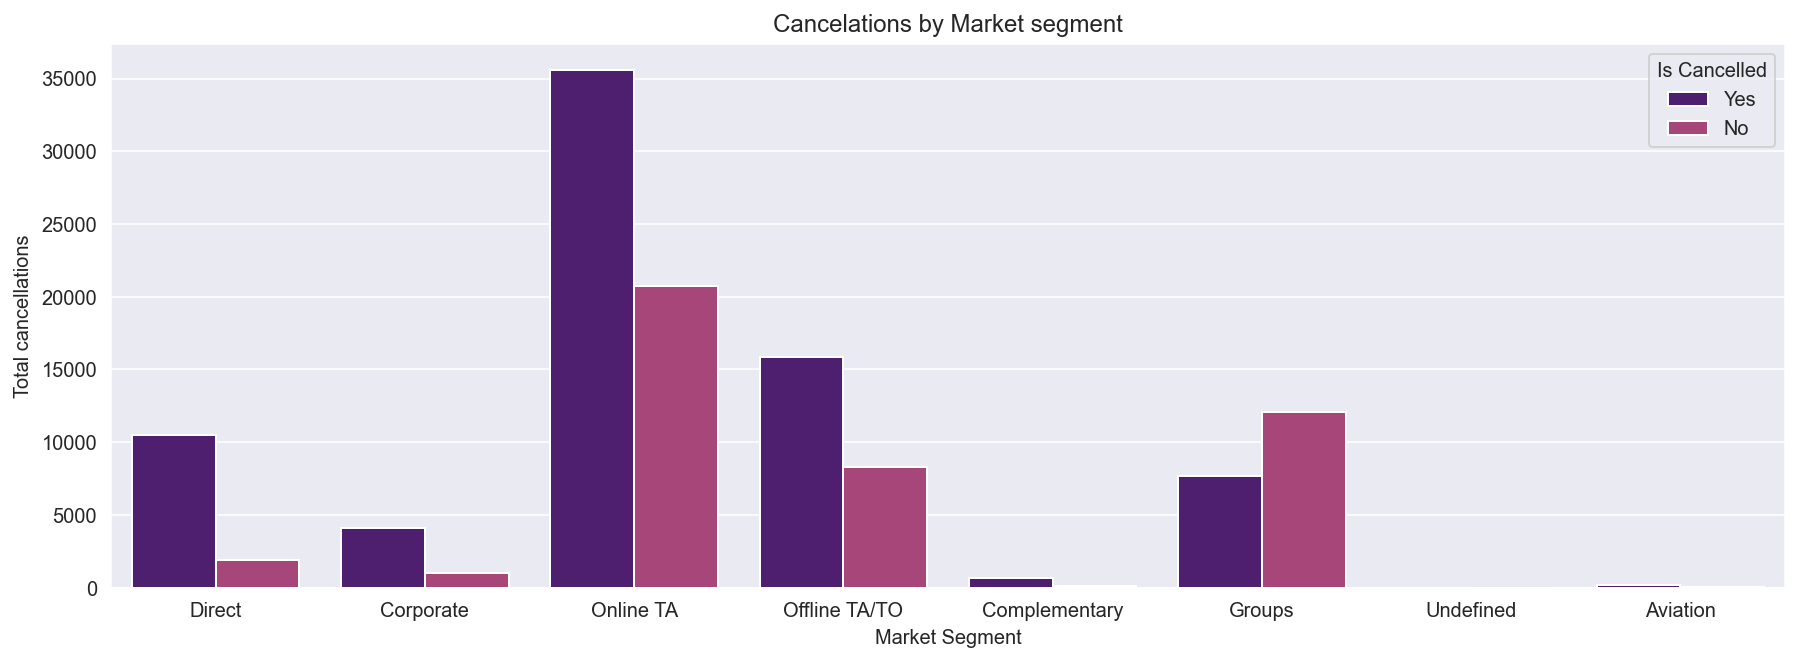

In [150]:
plt.subplots(figsize=(15,5))
fig=sns.countplot(data['market_segment'], hue=target)
fig.set(xlabel='Market Segment',ylabel='Total cancellations',title='Cancelations by Market segment')
plt.legend(['Yes','No'], title='Is Cancelled');

Cancellations when there have been previous cancellations: More probably that a booking is cancelled if the user has cancelled previously.

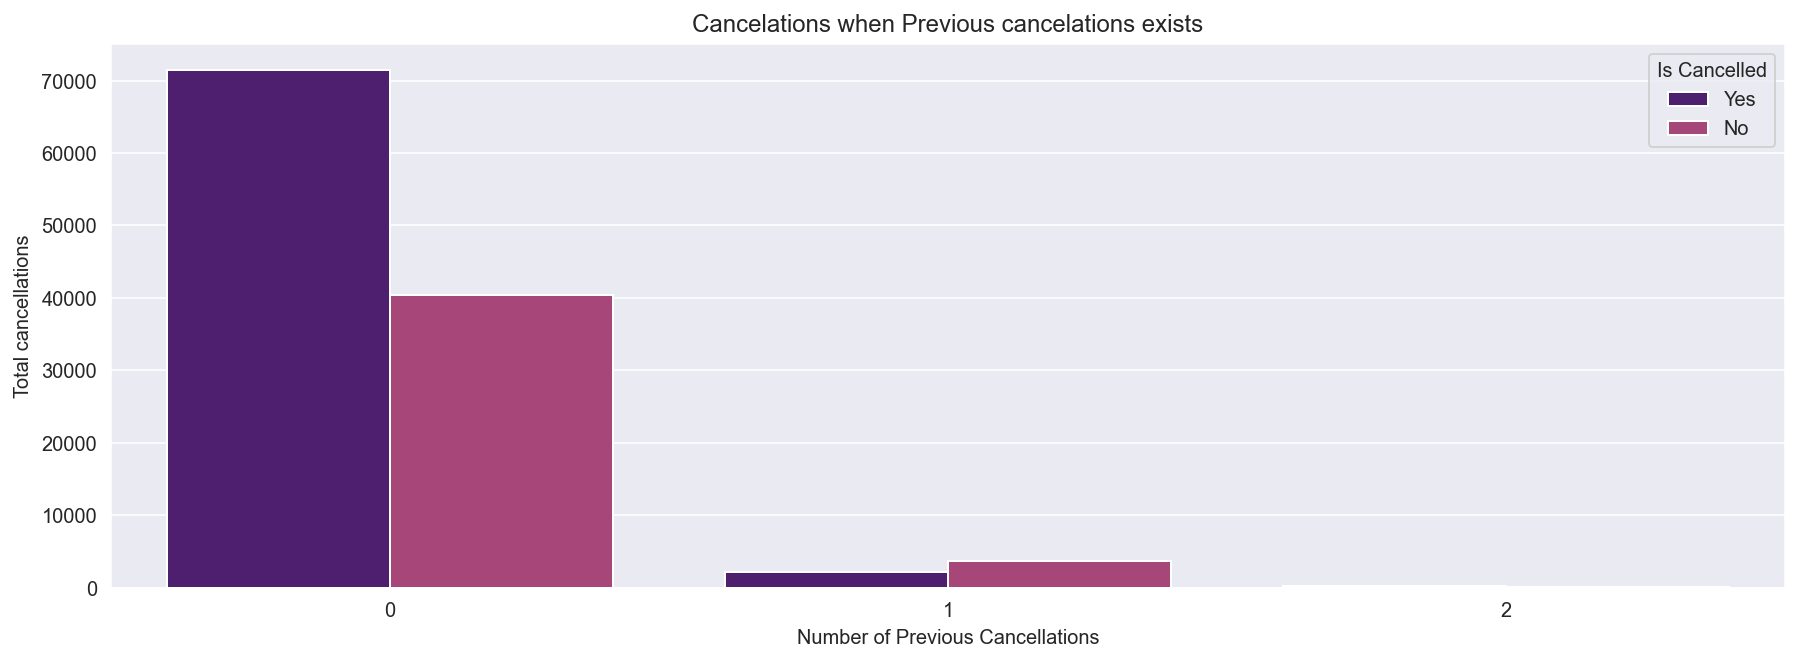

In [151]:
temp=data['previous_cancellations']
temp=pd.DataFrame([0 if i == 0 else 1 if i == 1 else 2 for i in temp], columns=['previous_cancellations'])
temp['is_canceled']=target
plt.subplots(figsize=(15,5))
fig=sns.countplot(temp['previous_cancellations'], hue=temp['is_canceled'])
fig.set(xlabel='Number of Previous Cancellations',ylabel='Total cancellations',title='Cancelations when Previous cancelations exists')
plt.legend(['Yes','No'], title='Is Cancelled');

DAYS IN WAITING LIST - CANCELLATIONS: For more than 2 Months in waiting list, the 50% of bookings are cancelled.

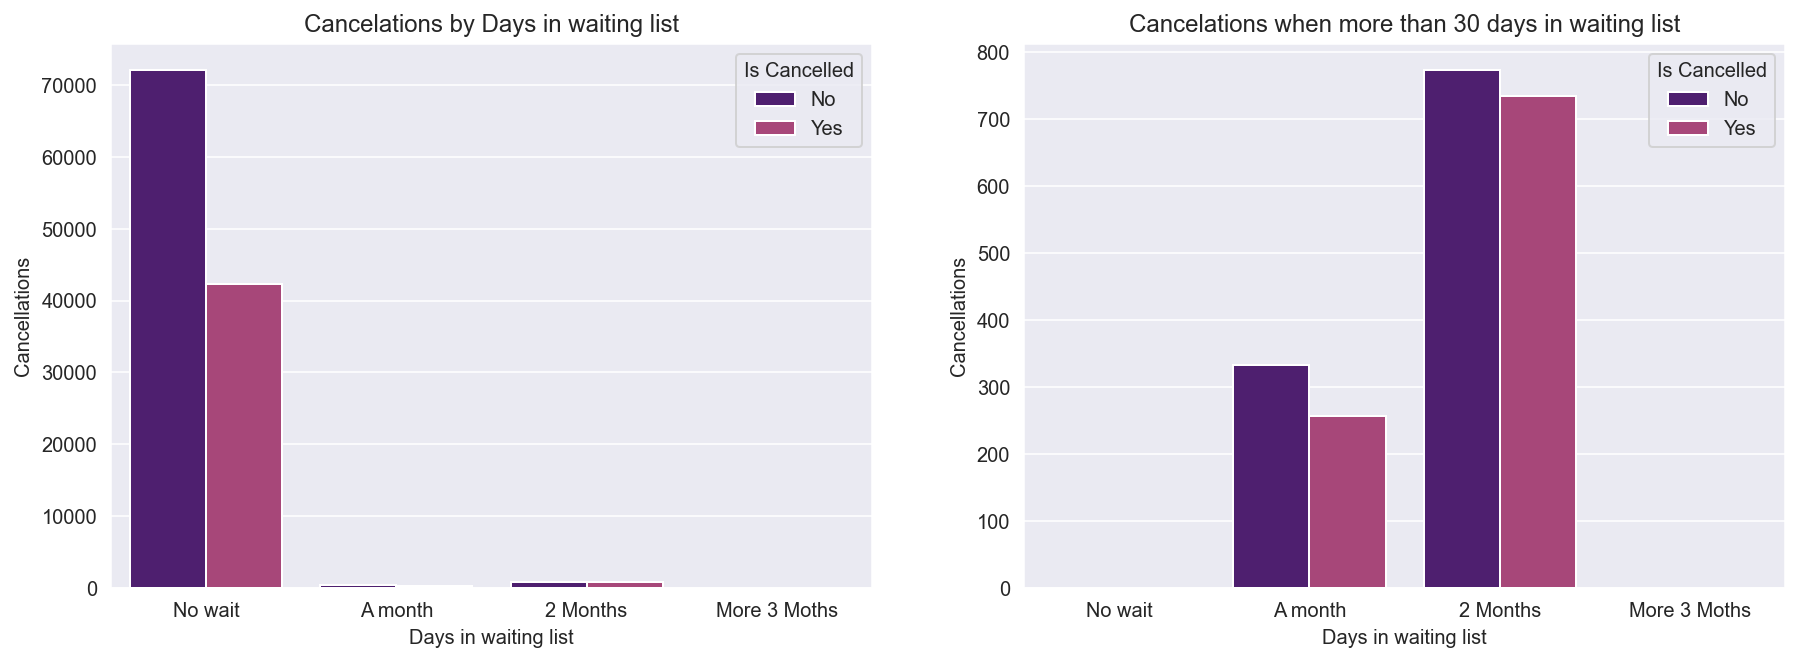

In [167]:
fig, axes= plt.subplots(1,2,figsize=(15,5))

temp=data['days_in_waiting_list']
temp=pd.DataFrame(['No wait' if i == 0 else 'A month' if 0<i<=30 else '2 Months' if 30<i<=60 else 'More 3 Months' for i in temp], 
                   columns=['days_wait_list'])
temp['is_canceled']=target
order_=['No wait','A month','2 Months','More 3 Moths']
g=sns.countplot(temp['days_wait_list'], hue=temp['is_canceled'], ax=axes[0], order=order_)
g.set(title='Cancelations by Days in waiting list', xlabel='Days in waiting list', ylabel='Cancellations')
g.legend(['No','Yes'], title='Is Cancelled', loc='upper right')

temp2=temp[temp['days_wait_list']!='No wait']
g=sns.countplot(temp2['days_wait_list'], hue=temp2['is_canceled'], 
              ax=axes[1], order=order_)
g.set(title='Cancelations when more than 30 days in waiting list', xlabel='Days in waiting list', ylabel='Cancellations')
g.legend(bbox_to_anchor=(1.02, 0.15),loc='upper right')
g.legend(['No','Yes'], title='Is Cancelled', loc='upper right');


CUSTOMER TYPE - CANCELLATIONS:

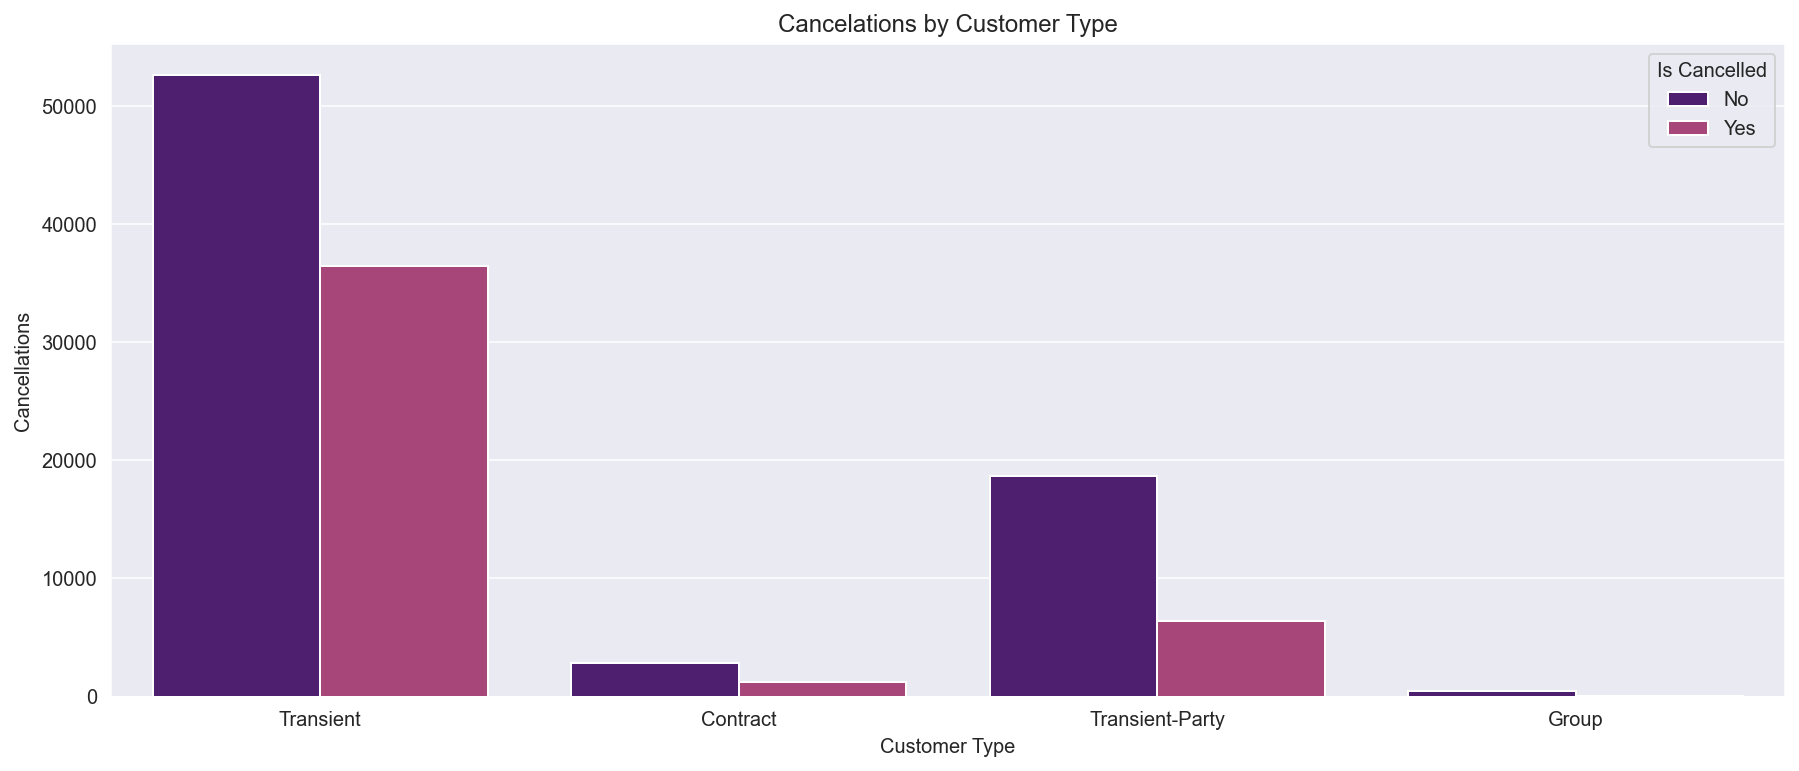

In [168]:
plt.subplots(figsize=(15,6))
g=sns.countplot(data['customer_type'], hue=data['is_canceled'])
g.set(title='Cancelations by Customer Type', xlabel='Customer Type', ylabel='Cancellations')
g.legend(['No','Yes'], title='Is Cancelled', loc='upper right');

NUMBER OF WEEK NIGHTS - CANCELLATIONS:

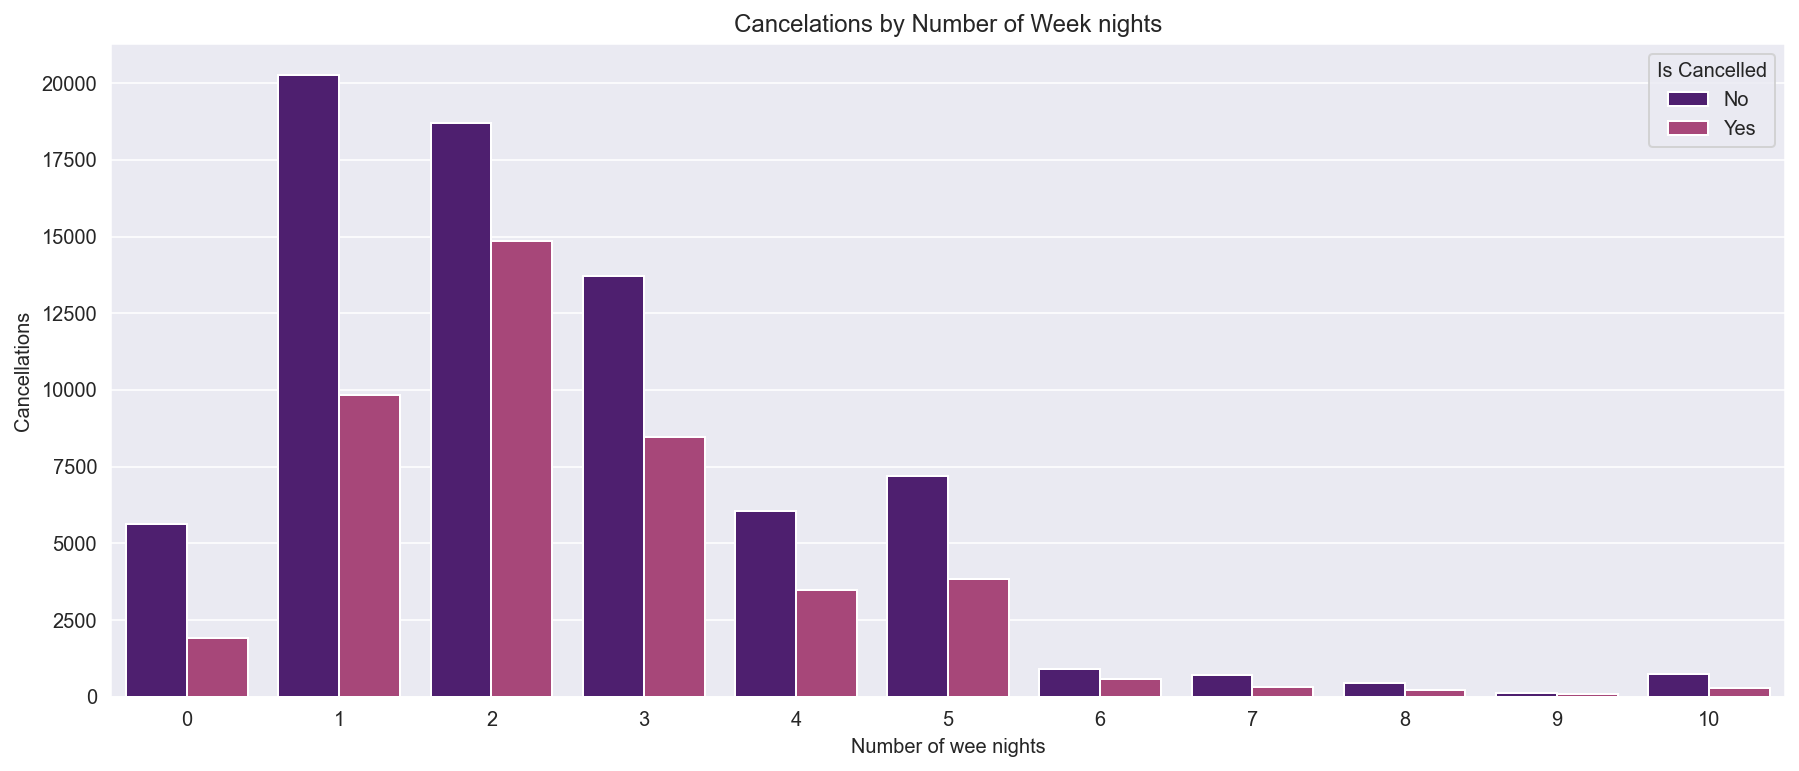

In [169]:
temp=data[data['stays_in_week_nights']<=10]

plt.subplots(figsize=(15,6))
g=sns.countplot(temp['stays_in_week_nights'], hue=temp['is_canceled'])
g.set(title='Cancelations by Number of Week nights', xlabel='Number of wee nights', ylabel='Cancellations')
g.legend(['No','Yes'], title='Is Cancelled', loc='upper right');

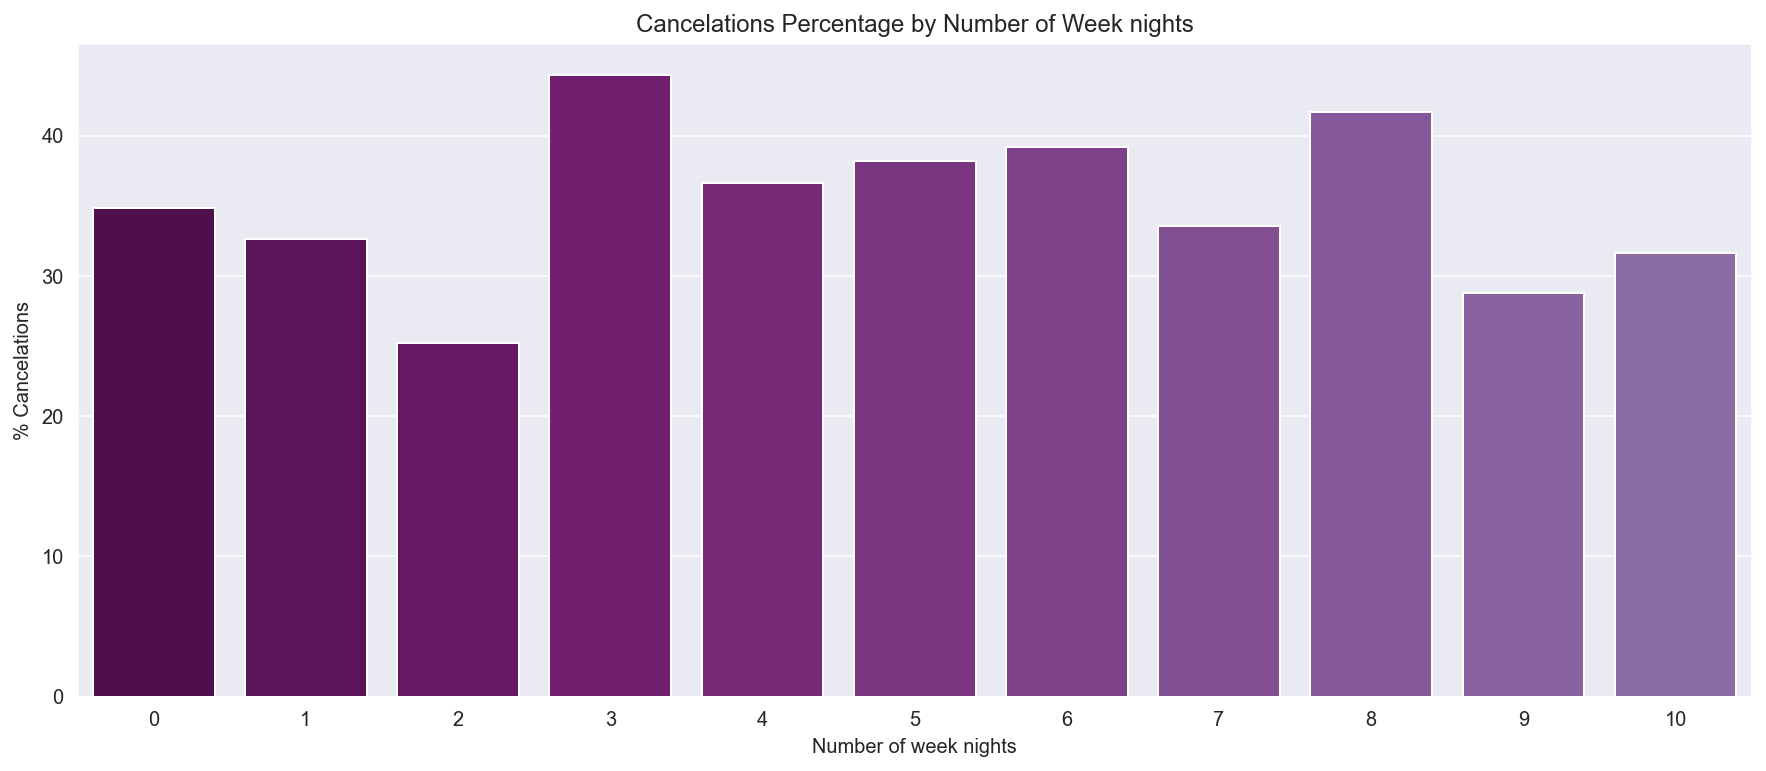

In [170]:
total_books=temp['stays_in_week_nights'].value_counts()
cancel_books=temp[temp['is_canceled']==1]['stays_in_week_nights'].value_counts()
percent=[100*(cancel_books[idx]/total_books[idx]) for idx, i in enumerate(total_books)]

plt.subplots(figsize=(15,6))
ax=sns.barplot(x=total_books.index, y=percent, palette=palette)
ax.set(title='Cancelations Percentage by Number of Week nights')
ax.set(ylabel='% Cancelations', xlabel='Number of week nights');

ARRIVAL DATE MONTH - CANCELLATIONS:

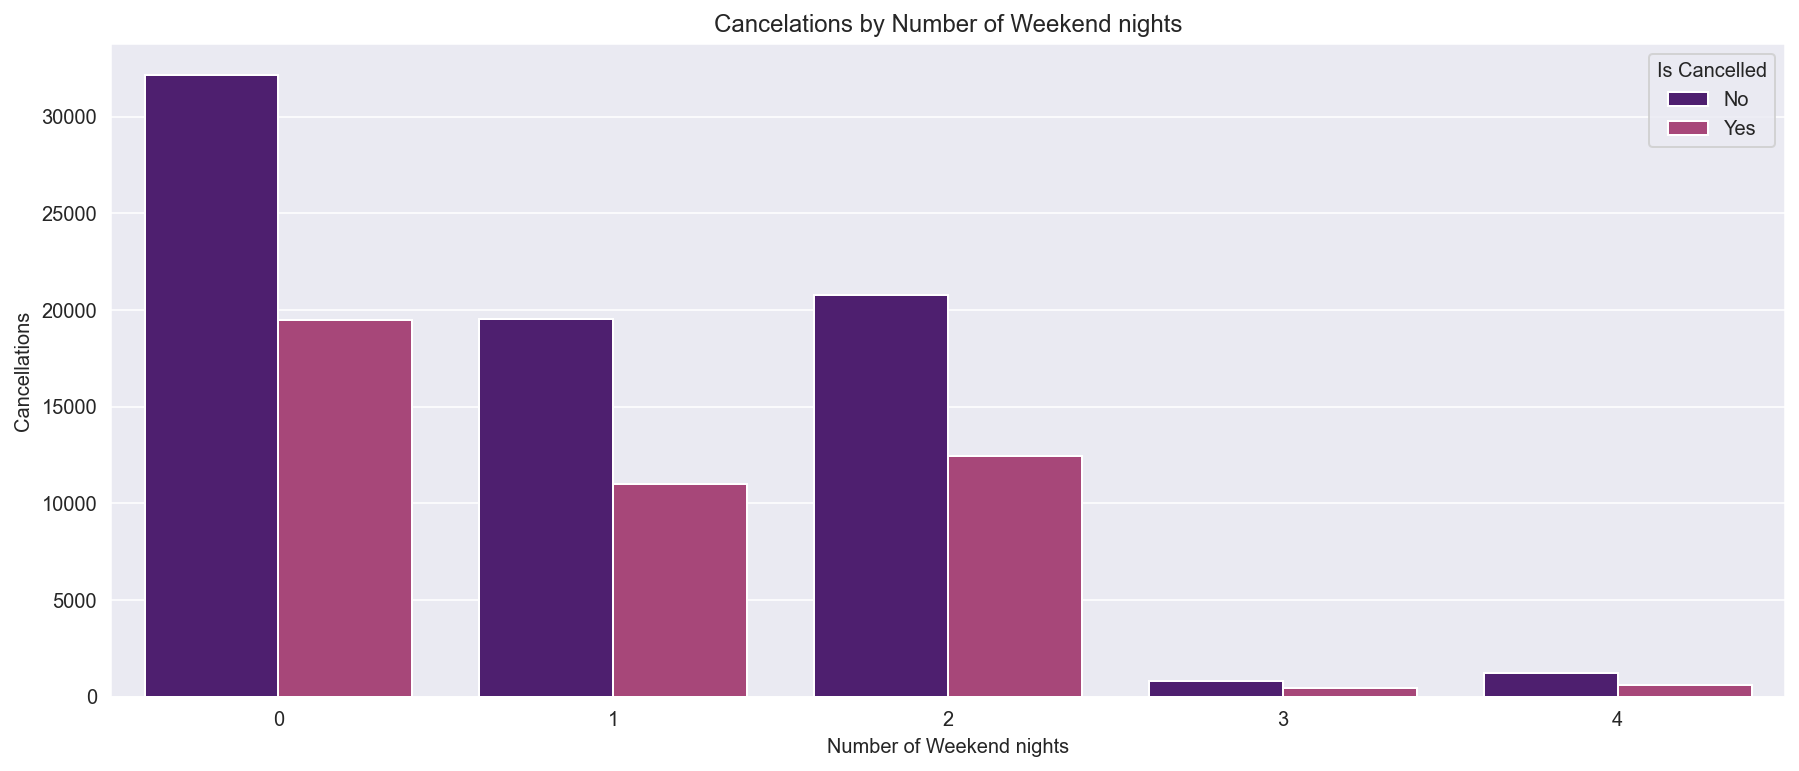

In [171]:
temp=data[data['stays_in_weekend_nights']<=4]
plt.subplots(figsize=(15,6))
g=sns.countplot(temp['stays_in_weekend_nights'], hue=temp['is_canceled'])
g.set(title='Cancelations by Number of Weekend nights')
g.set(xlabel='Number of Weekend nights', ylabel='Cancellations')
g.legend(['No','Yes'], title='Is Cancelled', loc='upper right');

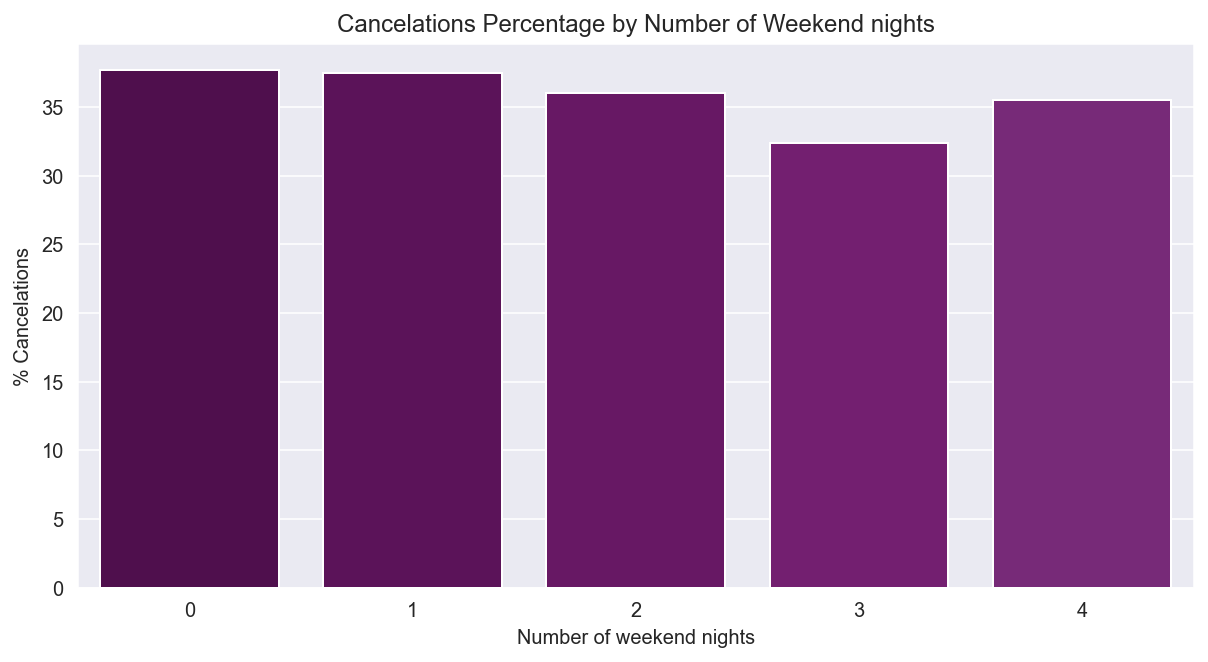

In [173]:
total_books=temp['stays_in_weekend_nights'].value_counts()
cancel_books=temp[temp['is_canceled']==1]['stays_in_weekend_nights'].value_counts()
percent=[100*(cancel_books[idx]/total_books[idx]) for idx, i in enumerate(total_books)]

plt.subplots(figsize=(10,5))
ax=sns.barplot(x=total_books.index, y=percent, palette=palette)
ax.set(title='Cancelations Percentage by Number of Weekend nights')
ax.set(ylabel='% Cancelations')
ax.set(xlabel='Number of weekend nights');

NUMBER OF WEEKEND NIGHTS - CANCELLATIONS:

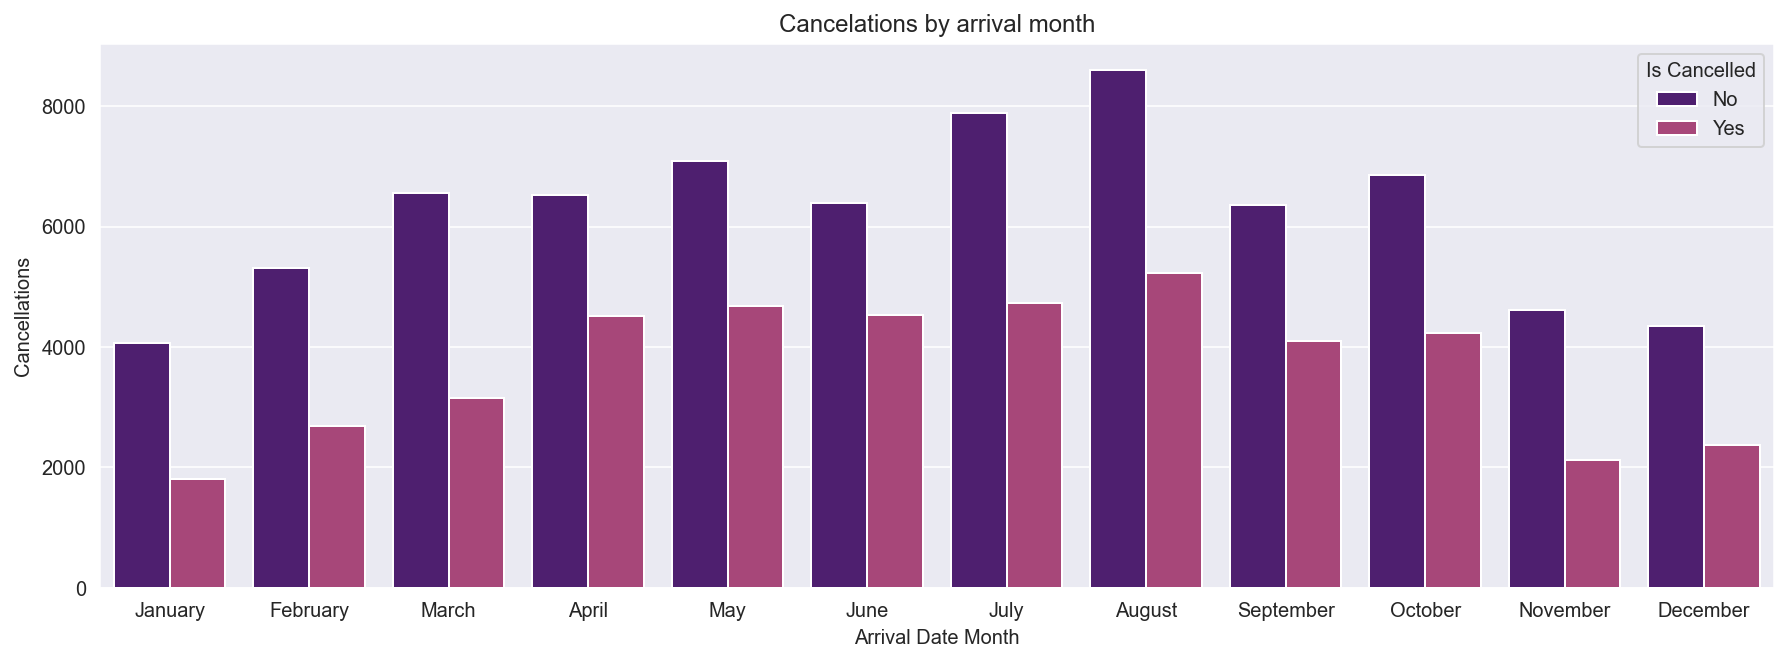

In [174]:
plt.subplots(figsize=(15,5))
g=sns.countplot(data['arrival_date_month'], hue=data['is_canceled'], order=monthly)
g.set(title='Cancelations by arrival month')
g.set(xlabel='Arrival Date Month', ylabel='Cancellations')
g.legend(['No','Yes'], title='Is Cancelled', loc='upper right');

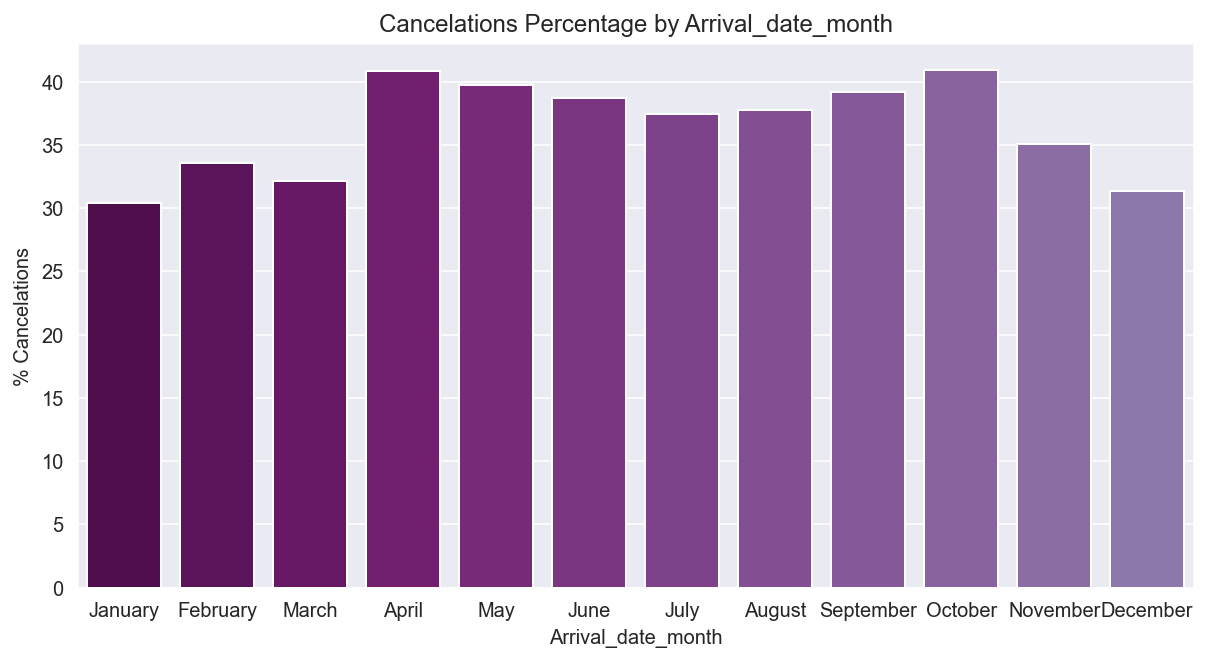

In [176]:
total_books=temp['arrival_date_month'].value_counts()
cancel_books=temp[temp['is_canceled']==1]['arrival_date_month'].value_counts()
percent=[100*(cancel_books[idx]/total_books[idx]) for idx, i in enumerate(total_books)]

plt.subplots(figsize=(10,5))
ax=sns.barplot(x=total_books.index, y=percent, order=monthly, palette=palette)
ax.set(title='Cancelations Percentage by Arrival_date_month')
ax.set(ylabel='% Cancelations')
ax.set(xlabel='Arrival_date_month');

### FEATURE ENGINEERING

#### ONE NEW VARIABLE

In [9]:
#Adding new variable: Arrival_date_trim

monthly=['January','February','March','April','May','June','July','August','September','October','November','December']
trims=[1,1,1,2,2,2,3,3,3,4,4,4]
trim_dict=dict(zip(monthly,trims))

data['arrival_date_trim']=data['arrival_date_month'].map(trim_dict)

#### MULTICOLLINEARITY

Let´s explore first the multicollinearity of all the features in our problem.

In [80]:
#Custom function to calculate the VIF value for a dataframe.

def vif_explore(data):
    
    ''' 
    This function takes as argument a dataframe and prints out a dataframe with the VIF factor of each feature.
        
    Input:  data (a dataframe)
    Output: dataframe with VIF factors
    
    '''
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    vif=pd.DataFrame()
    numerical=data.select_dtypes(exclude='object')
    vif['vif factor']=[variance_inflation_factor(numerical.values,i) for i in range(numerical.shape[1])]
    vif['Features']=numerical.columns
    return vif


In [63]:
vif_explore(data)

,vif factor,Features
0,1.928,is_canceled
1,2.393,lead_time
2,2.491,stays_in_weekend_nights
3,3.651,stays_in_week_nights
4,8.407,adults
5,1.213,children
6,1.024,babies
7,1.276,is_repeated_guest
8,1.062,previous_cancellations
9,1.258,previous_bookings_not_canceled


#### LINEAR CORRELATION

Multicollinearity is not excessive, let´s see correlations between numerical features. We will remove 'arrival_date_week_number' as it has a high correlation with our new variable 'arrival_date_trim'.

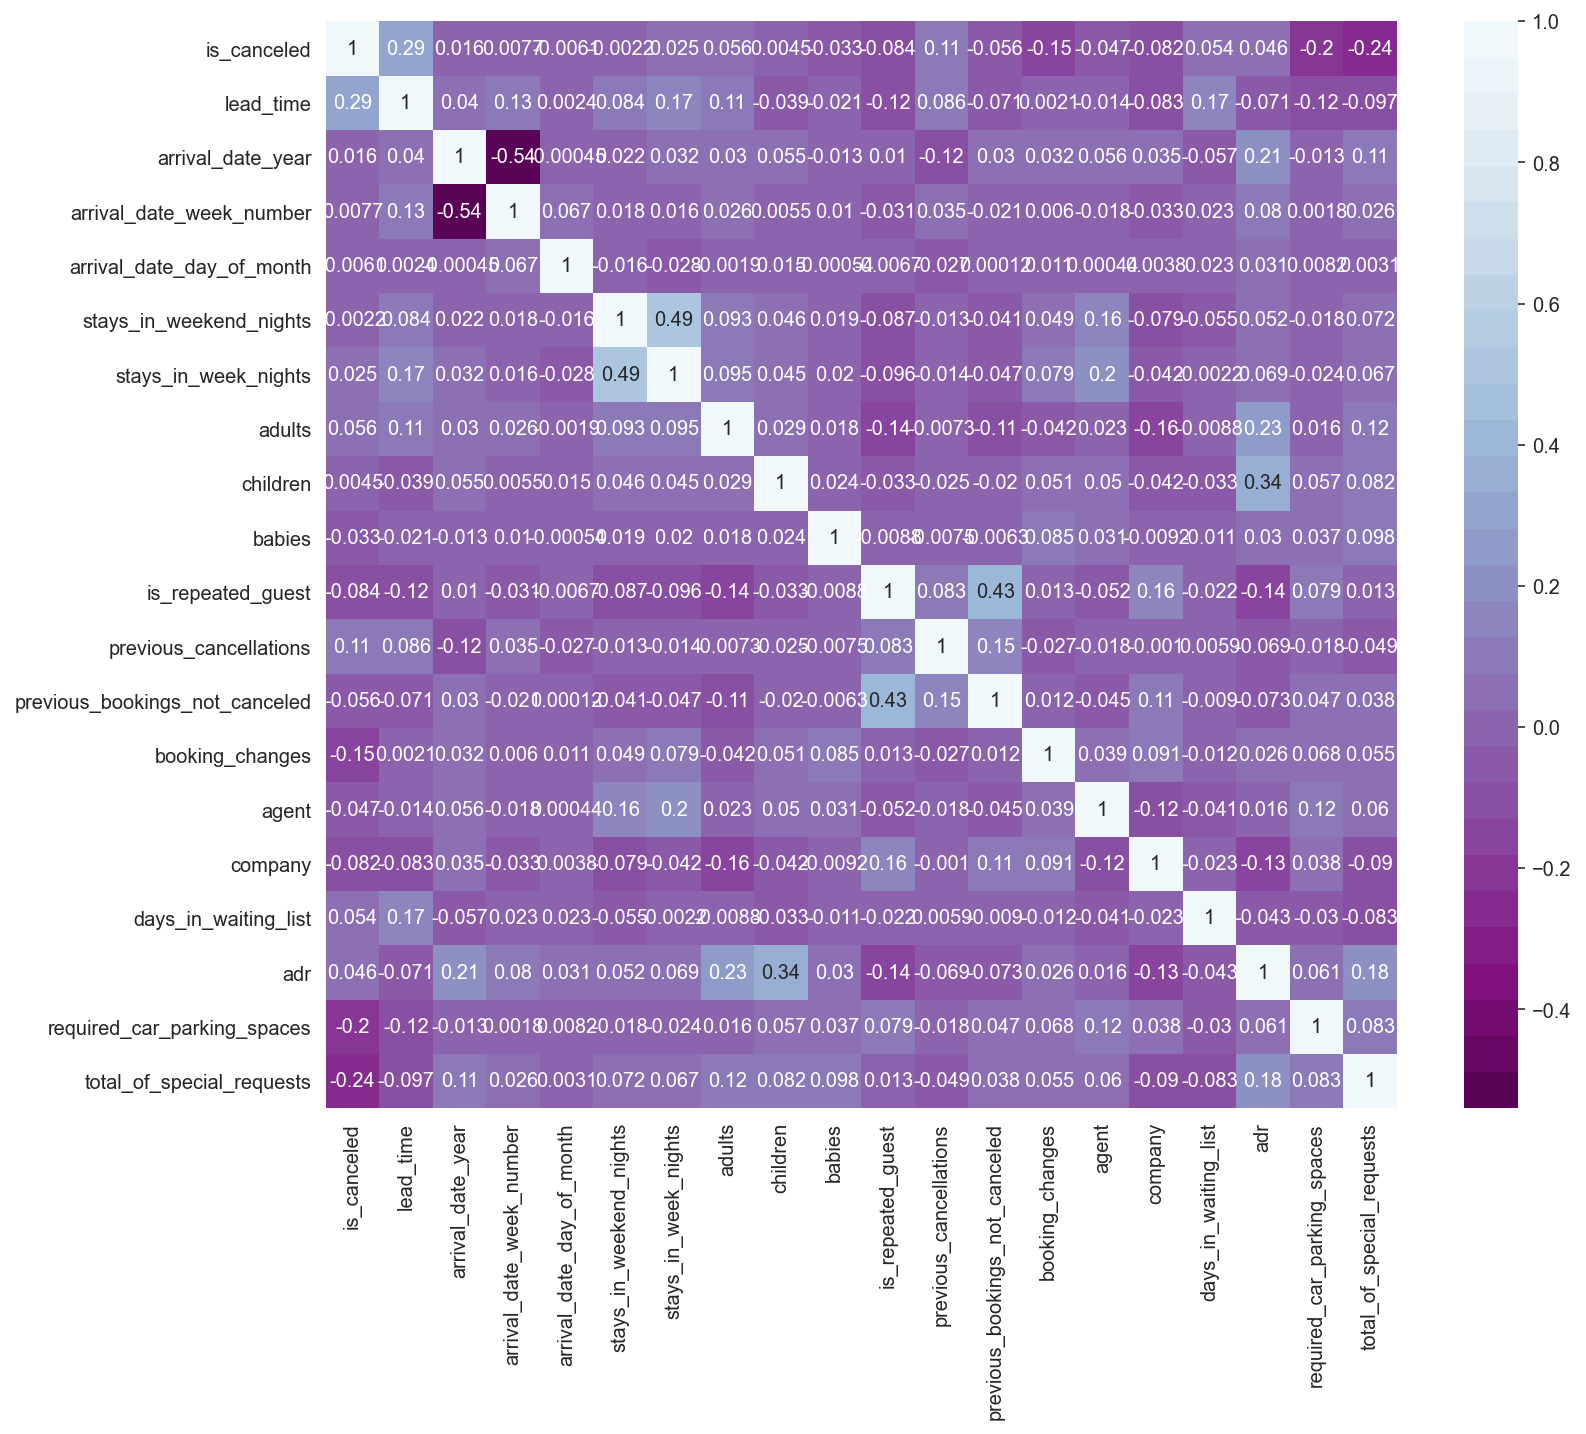

In [177]:
plt.subplots(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap=palette);

#### DROPPING REDUNDANT FEATURE

In [10]:
data=data.drop('arrival_date_week_number', axis=1)

#### CHANGING THE TYPE AND CARDINALITY 

We have to change the type of two variables: agent and company, as they are nominal features. Moreover, these two variables have a high cardinality as nominal features, so we will reduce it by binning them.

In [11]:
#Changing the type of some integer variables to nominal variables:

data['agent']=data['agent'].astype('str')
data['company']=data['company'].astype('str')
data['arrival_date_year']=data['arrival_date_year'].astype('str')
data['arrival_date_trim']=data['arrival_date_trim'].astype('str')

#Reducing cardinality in agent, company, country and arrival_date_day_of_month:

agents=['9','0','240','1','14','7','6','250','241','28','8','3','37']
companys=['0','40','223','67','45','153','174','219','281','154']
countries=['PRT','GBR','FRA','ESP','DEU','ITA','IRL','BEL','BRA','NLD']

data['agent']=data['agent'].apply(lambda x: 'Others' if x not in agents else x)
data['company']=data['company'].apply(lambda x: 'Others' if x not in companys else x)
data['country']=data['country'].apply(lambda x: 'Others' if x not in countries else x)
data['arrival_date_day_of_month']=[0 if 1<=i<10 else 1 if 10<=i<20 else 2 for i in data['arrival_date_day_of_month']]
data['arrival_date_day_of_month']=data['arrival_date_day_of_month'].astype('str')

### PREPROCESSING

Let´t take a look to the final subsets of numerical and categorical features.

In [15]:
data.select_dtypes(exclude='O').head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,0,0,2,0,0,0,0,0,3,0,0.000,0,0
1,0,737,0,0,2,0,0,0,0,0,4,0,0.000,0,0
2,0,7,0,1,1,0,0,0,0,0,0,0,75.000,0,0
3,0,13,0,1,1,0,0,0,0,0,0,0,75.000,0,0
4,0,14,0,2,2,0,0,0,0,0,0,0,98.000,0,1


In [16]:
data.select_dtypes('object').head()

,hotel,arrival_date_year,arrival_date_month,arrival_date_day_of_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,agent,company,customer_type,arrival_date_trim
0,Resort Hotel,2015,July,0,BB,PRT,Direct,Direct,C,C,No Deposit,0,0,Transient,3
1,Resort Hotel,2015,July,0,BB,PRT,Direct,Direct,C,C,No Deposit,0,0,Transient,3
2,Resort Hotel,2015,July,0,BB,GBR,Direct,Direct,A,C,No Deposit,0,0,Transient,3
3,Resort Hotel,2015,July,0,BB,GBR,Corporate,Corporate,A,A,No Deposit,Others,0,Transient,3
4,Resort Hotel,2015,July,0,BB,GBR,Online TA,TA/TO,A,A,No Deposit,240,0,Transient,3


#### SPLITTING INTO TRAIN AND TEST SETS

Before performing any transformation in our data, we need to split into train and test sets to avoid Data Leakage.

In [12]:
from sklearn.model_selection import train_test_split

target=data['is_canceled']
data=data.drop('is_canceled', axis=1)
data_train,data_test,target_train,target_test=train_test_split(data,target,test_size=0.2,random_state=42)

numerical=data.select_dtypes(exclude='O')
categorical=data.select_dtypes('O')

#### SCALING NUMERICAL FEATURES

We will try several scaling methods to compare results and to see which is the best one for our data. We have to take into account that we have a boolean feature in the numerical subset ('is_repeated_guest') that we should avoid to scale.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

def scaler_func(data_train, data_test, method):
    
    '''
    This functions takes train and test sets as inputs and performs the scaling method specified in 'method' argument
    in both datasets.
    
    Inputs: data_train ( train dataframe)
            data_test ( test dataframe)
            method (min for MinMaxScaler, std for StandardScaler or rob for RobustScaler)
            
    Outputs:data_scaled for train and test sets (dataframes with numerical features scaled)
    '''
    
    numerical=data.select_dtypes(exclude='O')
    numerical=numerical[numerical.columns.difference(['is_repeated_guest'])]
    columns=numerical.columns
    
    #Scaling dataset
    
    if method=='min':
        scaler=MinMaxScaler()
    elif method=='std':
        scaler=StandardScaler()
    else:
        scaler=RobustScaler()
    
    
    train_scaled=pd.DataFrame(scaler.fit_transform(data_train[columns]))
    test_scaled=pd.DataFrame(scaler.transform(data_test[columns]))
    
    train_scaled.columns=test_scaled.columns=numerical.columns
    train_scaled.index=data_train.index
    test_scaled.index=data_test.index
    data_train=data_train.drop(numerical.columns, axis=1)
    data_test=data_test.drop(numerical.columns, axis=1)
    data_train=data_train.join(train_scaled)
    data_test=data_test.join(test_scaled)
    
    return data_train, data_test

data_train_min, data_test_min=scaler_func(data_train, data_test, 'min')
data_train_std, data_test_std=scaler_func(data_train, data_test, 'std')
data_train_rob, data_test_rob=scaler_func(data_train, data_test, 'rob')

#### ONE HOT ENCODING FOR CATEGORICALS

The selected method for encoding categorical features has been One Hot Encoding, as we don´t have our model gives more importance to some values over others, which would be the case with a Label Encoding.

In [14]:
import category_encoders as ce 

OneHot=ce.one_hot.OneHotEncoder(return_df=True, use_cat_names=True)
train_onehot=OneHot.fit_transform(data_train[categorical.columns])

test_onehot=OneHot.transform(data_test[categorical.columns])

In [15]:
#Ensembling dataframe scaled and one hot encoding.

data_train_min=data_train_min.drop(categorical.columns, axis=1)
data_train_min=data_train_min.join(train_onehot)

data_train_std=data_train_std.drop(categorical.columns, axis=1)
data_train_std=data_train_std.join(train_onehot)

data_train_rob=data_train_rob.drop(categorical.columns, axis=1)
data_train_rob=data_train_rob.join(train_onehot)

data_test_min=data_test_min.drop(categorical.columns, axis=1)
data_test_min=data_test_min.join(test_onehot)

data_test_std=data_test_std.drop(categorical.columns, axis=1)
data_test_std=data_test_std.join(test_onehot)

data_test_rob=data_test_rob.drop(categorical.columns, axis=1)
data_test_rob=data_test_rob.join(test_onehot)    

#### BALANCE OF TARGET

Let´s see the proportion of cases in target to select an appropiate metric value. Classes are a little unbalanced.

In [25]:
target_train.value_counts(100)

0   0.629
1   0.371
Name: is_canceled, dtype: float64

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

def sgdcmodel(data_train, data_test, target_train, target_test):
    
    model=SGDClassifier(loss='hinge',random_state=5,n_jobs=8)
    model.fit(data_train,target_train)
    ypred=model.predict(data_test)
    roc_test=roc_auc_score(target_test,ypred, average=None)
    
    return roc_test

sgdcmodel(data_train_min, data_test_min, target_train, target_test)
sgdcmodel(data_train_std, data_test_std, target_train, target_test)
sgdcmodel(data_train_rob, data_test_rob, target_train, target_test)


0.7935843683040615

0.8136651891899656

0.8085226253502347

It seems that we reach a better performance with Standard Scaling, so we will take this dataset as the best one for hyperparameter tuning to improve the model.

### FEATURE SELECTION

Before proceeding with modelizaztion, let´s see if we can check the improvement of the model performance with some feature selection techniques. For this purposes, we will perform an Ordinal Encoding over categorical features to make it simpler.

In [16]:
#Standard scaling for train and test sets

data_train_scaled, data_test_scaled=scaler_func(data_train, data_test, 'std')

#Ordinal encoding

import category_encoders as ce 

Label_enc=ce.ordinal.OrdinalEncoder(return_df=True)
train_label=Label_enc.fit_transform(data_train[categorical.columns])
test_label=Label_enc.transform(data_test[categorical.columns])

data_train_scl=data_train_scaled.drop(categorical.columns, axis=1)
data_train_scl=data_train_scl.join(train_label)
data_test_scl=data_test_scaled.drop(categorical.columns, axis=1)
data_test_scl=data_test_scl.join(test_label)


#### FILTER METHODS

 We already have our features as numerical, so we can use Mutual Information. This method relies on 
non-parametric methods, so we don´t need to check major assumptions over the dataset. With this method we can order the features according to the level of relationship with the target.

In [18]:
from sklearn.feature_selection import mutual_info_classif as MIC
mic_score = MIC(data_train_scl,target_train)
dict_=dict(zip(data_train_scl.columns,mic_score))
sorted(dict_.items(), key=lambda x: x[1])

[('is_repeated_guest', 0.0),
 ('babies', 0.0026454612933424215),
 ('arrival_date_day_of_month', 0.002750337076386833),
 ('arrival_date_month', 0.0032006299131812632),
 ('children', 0.0037328755454546503),
 ('arrival_date_trim', 0.0038233258688571414),
 ('adults', 0.005059431697348904),
 ('stays_in_weekend_nights', 0.006227562067576908),
 ('arrival_date_year', 0.006685239471572402),
 ('reserved_room_type', 0.007878424486664093),
 ('stays_in_week_nights', 0.008306636541873802),
 ('previous_bookings_not_canceled', 0.009911030950893851),
 ('meal', 0.0102416622318382),
 ('customer_type', 0.016892265211440716),
 ('days_in_waiting_list', 0.017361545194439776),
 ('hotel', 0.017528063486366374),
 ('company', 0.019189052603398205),
 ('assigned_room_type', 0.0231899319508857),
 ('distribution_channel', 0.02360274921693506),
 ('booking_changes', 0.023698473173381362),
 ('required_car_parking_spaces', 0.03370893235110106),
 ('market_segment', 0.03812803069463122),
 ('total_of_special_requests', 0.0

#### WRAPPER METHODS

##### Forward selection with 'mlxtend' package 

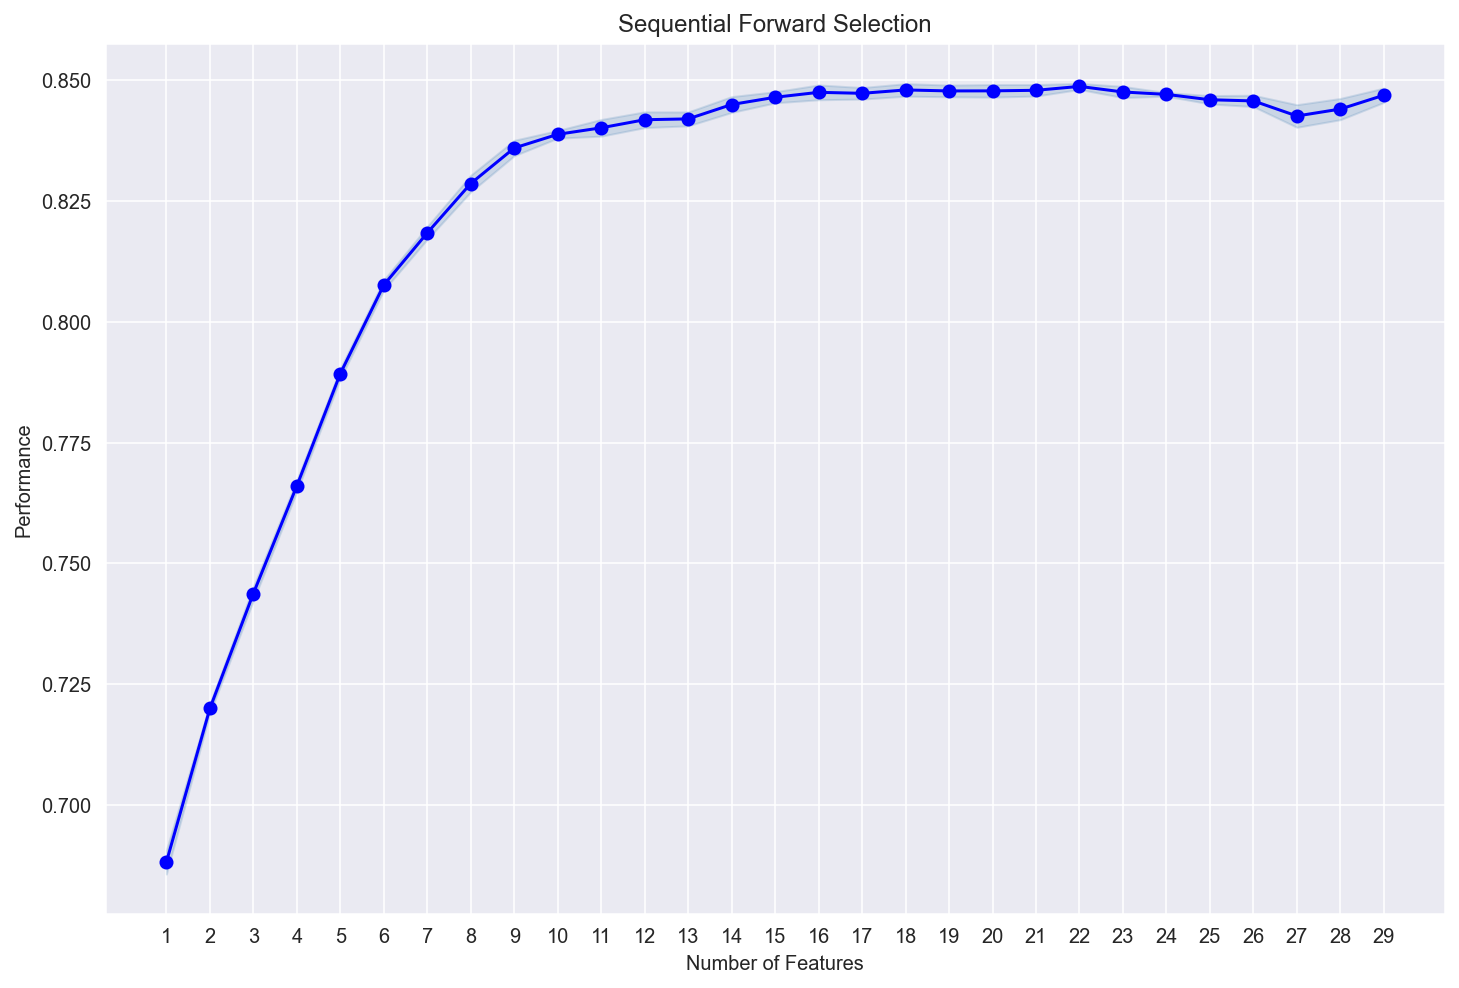

In [29]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

sgd=SGDClassifier(loss='hinge',random_state=5,n_jobs=-1)
sfs = SFS(sgd, 
          k_features=(7,29), 
          forward=True, 
          floating=False, 
          scoring='roc_auc',
          cv=5)

sfs = sfs.fit(data_train_scl, target_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(12, 8))

plt.title('Sequential Forward Selection');

As we can see in the plot above, the performance grows fast as we increase the number of features until 22 features witch is the optimum number:

In [30]:
sfs_results=pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_results[sfs_results['avg_score']==sfs_results['avg_score'].max()]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
22,"(0, 1, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 1...","[0.8466932234980649, 0.8487947290302638, 0.850...",0.849,"(is_repeated_guest, adr, babies, booking_chang...",0.002,0.001,0.001


In [31]:
#Best features:

sfs.k_feature_names_

('is_repeated_guest',
 'adr',
 'babies',
 'booking_changes',
 'days_in_waiting_list',
 'lead_time',
 'previous_bookings_not_canceled',
 'previous_cancellations',
 'required_car_parking_spaces',
 'stays_in_weekend_nights',
 'total_of_special_requests',
 'hotel',
 'arrival_date_year',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'company',
 'customer_type',
 'arrival_date_trim')

##### Minimum Redundancy Maximum Relevance (mRMR)

This method is a heuristic algorithm to find a close to optimal subset of features by considering both the features importances and the correlations between them. The idea is that, even if two features are highly relevant, it may not be a good idea to add both of them to the feature set if they are highly correlated. In that case, adding both features would increase the model complexity (increasing the possibility of overfitting) but would not add significant information, due to the correlation between the features. This selection method was developed to overcome with the idea that "The best K features is not the same as the K Best Features", and we want to find the best K features for the target, and at the same time with the least correlation with others.

This method calculates the difference between the Relevance and the redundancy of a feature, taking into account the Mutual information value.

In [50]:
from mrmr import mrmr_classif
selected_features = mrmr_classif(data_train_scl, target_train, K = 22)
selected_features

100%|██████████| 22/22 [00:05<00:00,  4.39it/s]


['deposit_type',
 'required_car_parking_spaces',
 'lead_time',
 'total_of_special_requests',
 'booking_changes',
 'market_segment',
 'previous_cancellations',
 'hotel',
 'distribution_channel',
 'customer_type',
 'assigned_room_type',
 'is_repeated_guest',
 'days_in_waiting_list',
 'adults',
 'company',
 'babies',
 'previous_bookings_not_canceled',
 'country',
 'reserved_room_type',
 'adr',
 'stays_in_week_nights',
 'arrival_date_year']

##### Comparison of both methods

Both methods select different subsets of features, but the performance of the model with both subsets is nearly the same. We obtain a slightly better behaviour with the subset selected by mRMR but it is not very significative.

In [54]:
#Features selected by mRMR but not selected by mlxtend method

print('Features selected by mRMR but not in mlxtend method:\n')
[i for i in selected_features if i not in list(sfs.k_feature_names_)]

#Features selected by mlxtend method but not selected by mRMR

print('Features selected by mlxtend method but not in mRMR:\n')
[i for i in list(sfs.k_feature_names_) if i not in selected_features]

Features selected by mRMR but not in mlxtend method:



['adults', 'country', 'stays_in_week_nights']

Features selected by mlxtend method but not in mRMR:



['stays_in_weekend_nights', 'meal', 'arrival_date_trim']

In [55]:
#Model performance with each subset of features:

print('ROC-AUC with mRMR subset:\n')
sgdcmodel(data_train_scl[selected_features], data_test_scl[selected_features], target_train, target_test)

print('ROC-AUC with mlxtend package subset:\n')
sgdcmodel(data_train_scl[list(sfs.k_feature_names_)], data_test_scl[list(sfs.k_feature_names_)], target_train, target_test)

ROC-AUC with mRMR subset:



0.7193501256932405

ROC-AUC with mlxtend package subset:



0.7142069079689627

Now, let´s try to find an optimum number of features with the mRMR method. We will take into account a subset between 22 and all the features. We can appreciate that the best result is obtained with all the features in the dataset.

In [60]:
for i in [22,23,24,25,26,27,28]:
    selected_features = mrmr_classif(data_train_scl, target_train, K = i)
    sgdcmodel(data_train_scl[selected_features], data_test_scl[selected_features], target_train, target_test)

100%|██████████| 22/22 [00:05<00:00,  4.35it/s]


0.7193501256932405

100%|██████████| 23/23 [00:05<00:00,  4.23it/s]


0.7207235893952777

100%|██████████| 24/24 [00:05<00:00,  4.37it/s]


0.7234181002045941

100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


0.7121690144145636

100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


0.7086022367387111

100%|██████████| 27/27 [00:07<00:00,  3.83it/s]


0.7092648636839705

100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


0.7270830739528303

100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


0.7270830739528303

#### EMBEDDING METHODS

##### Feature Importance with tree-based models and SHAP

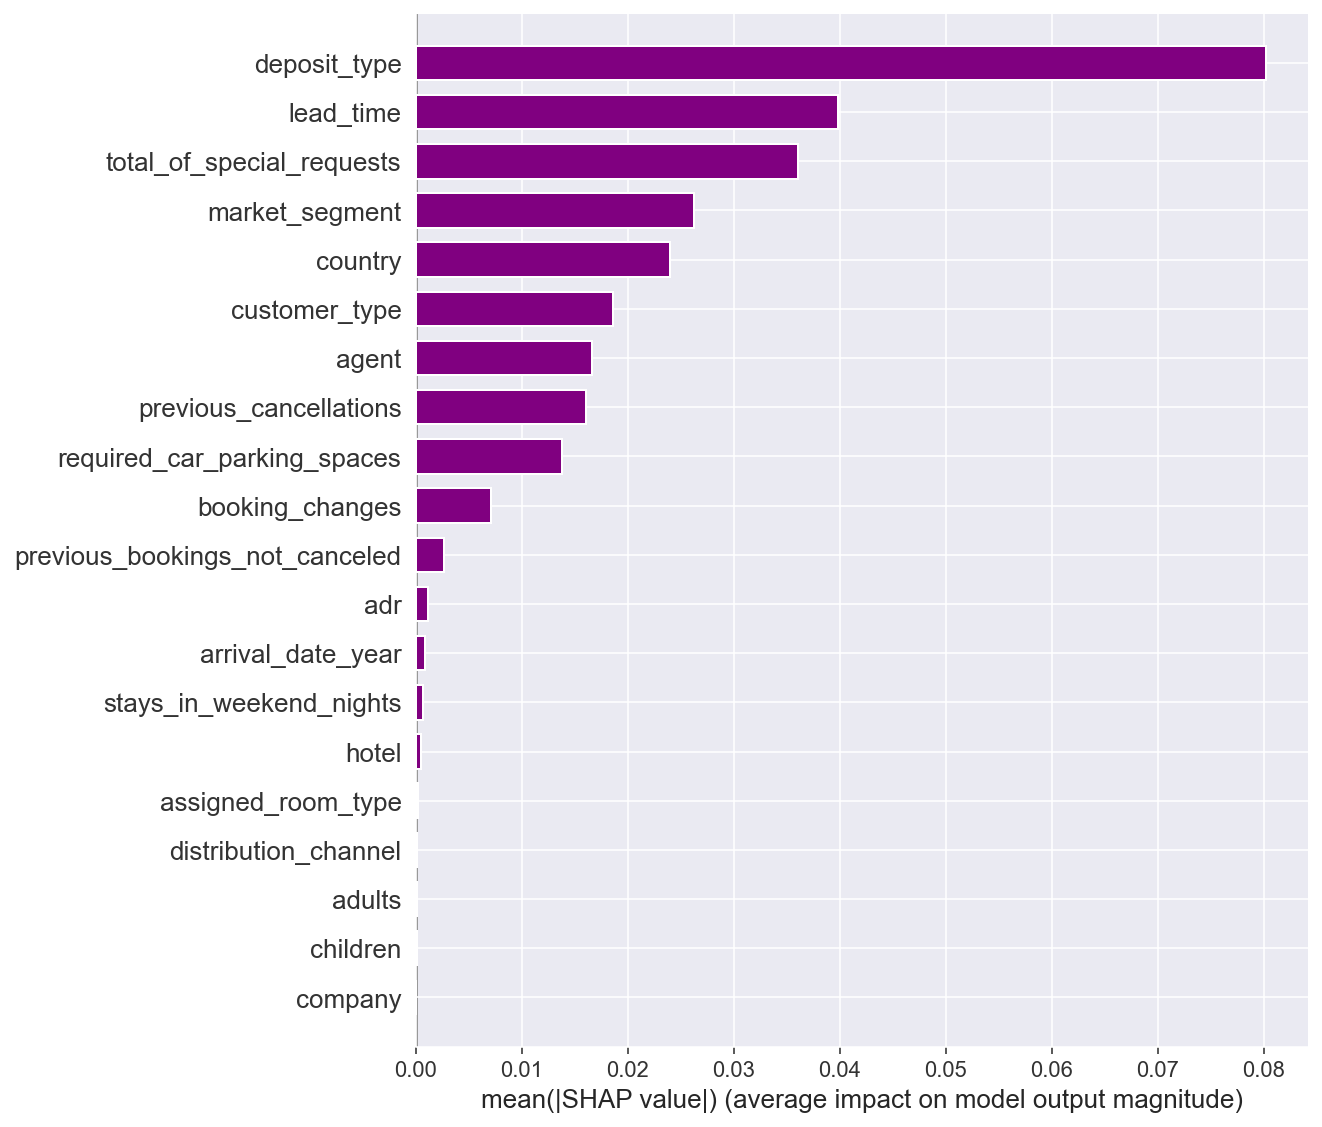

In [178]:
#SHAP: 

import xgboost
import shap
# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(data_train_scl, label=target_train), 100)
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_train_scl)
shap.summary_plot(shap_values, data_train_scl, plot_type="bar", color='purple')

As we don´t have a high number of features and it seems there are not big differences in the behaviour of the model with a smaller subset, we will consider the entire subset of features for modeling.

### MODELING

Some algorythms as SVC, KNN don´t work well on large datasets as this case (more than 100000 samples), so we will try with some other ones.

In [18]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score,f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

SGDC=SGDClassifier(random_state=5,n_jobs=8)
XGBC=xgb.XGBClassifier(random_state=8, n_jobs=-1)
LGBMC=lgb.LGBMClassifier(objective='binary',random_state=9,n_jobs=-1)
LR=LogisticRegression(random_state=3, solver='sag')
RFC=RandomForestClassifier(random_state=4,n_jobs=8)
GBC=GradientBoostingClassifier(random_state=7)


models=[SGDC,XGBC,LGBMC,LR,RFC,GBC]
models_names=['SGDC','XGBC','LGBMC','LR','RFC','GBC']
acc_train=[]
acc_test=[]
f1train=[]
f1test=[]

for model in models:
    model.fit(data_train_std,target_train)
    ypred_train=model.predict(data_train_std)
    ypred=model.predict(data_test_std)
    
    accuracy_train=accuracy_score(target_train,ypred_train)
    acc_train.append(accuracy_train)
                         
    accuracy_test=accuracy_score(target_test,ypred)
    acc_test.append(accuracy_test) 
                         
    f1_train=f1_score(target_train,ypred_train)
    f1train.append(f1_train)                 
    
    f1_test=f1_score(target_test,ypred)
    f1test.append(f1_test)
                         
acc=pd.DataFrame([acc_train,acc_test,f1train,f1test])
acc.columns=models_names

SGDClassifier(n_jobs=8, random_state=5)

[10:04:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

LGBMClassifier(objective='binary', random_state=9)

LogisticRegression(random_state=3, solver='sag')

RandomForestClassifier(n_jobs=8, random_state=4)

GradientBoostingClassifier(random_state=7)

#### Result Dataframe

Results for several metrics can be found in the dataframe below. As we have an unbalanced dataset, we will focus on the f1Score metric. The best performance is reach with Random Forest although there is overfitting. Also XGBoost and LightGBM perform well, near to Random Forest and with less overfitting. So we will tune these three models for optimal performance.

In [20]:
acc.index=['acc_train', 'acc_test', 'F1_train', 'F1_test']
acc

,SGDC,XGBC,LGBMC,LR,RFC,GBC
acc_train,0.827,0.894,0.882,0.826,0.996,0.856
acc_test,0.828,0.878,0.875,0.825,0.895,0.852
F1_train,0.766,0.854,0.835,0.749,0.995,0.792
F1_test,0.768,0.832,0.827,0.747,0.854,0.789


#### HYPERPARAMETER TUNING FOR THE THREE BEST MODELS

Using Bayesian Optimization we can find better values for the models parameters.

In [99]:
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll import scope

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb


params_RFC     ={'type':'RFC',
                 'n_estimators':hp.randint('n_estimators',100,200),
                 'max_features':hp.choice('max_features',['auto','sqrt','log2']),
                 'max_depth':scope.int(hp.quniform('max_depth',2,15,1)),
                 'min_samples_split':scope.int(hp.quniform('min_samples_split',1,10,1)),
                 'min_samples_leaf':scope.int(hp.quniform('min_samples_leaf',1,10,1)),
                 'bootstrap':hp.choice('bootstrap',[True,False])
                }

params_XGBoost ={'type':'XGBoost',
                 'colsample_bytree':hp.uniform("colsample_bytree", 0.5, 1.0), 
                 'gamma':hp.uniform("gamma", 0.0, 5.0), 
                 'learning_rate':hp.loguniform("learning_rate", np.log(0.01), np.log(0.7)), 
                 'max_depth':scope.int(hp.quniform("max_depth", 2, 15,1)), 
                 'min_child_weight':hp.uniform("min_child_weight", 0, 1), 
                 'n_estimators':scope.int(hp.quniform('n_estimators',10,200,1)),
                 'reg_alpha':hp.uniform("reg_alpha", 0, 1), 
                 'reg_lambda':hp.uniform("reg_lambda", 0.0, 1.5),
                 'subsample':hp.uniform("subsample", 0.1, 1)
                }

params_LGBMC    ={'type':'LGBMC',
                  'n_estimators':scope.int(hp.quniform('n_estimators',150,250,1)),
                  'colsample_bytree':hp.uniform("colsample_bytree", 0.1, 1.0), 
                  'learning_rate':hp.loguniform("learning_rate", np.log(0.01), np.log(0.7)), 
                  'max_depth':scope.int(hp.quniform("max_depth", 30, 60,1)), 
                  'min_child_weight':hp.uniform("min_child_weight", 0, 1), 
                  'reg_alpha':hp.quniform("reg_alpha", 1.1, 3.0, 0.1), 
                  'reg_lambda':hp.uniform("reg_lambda", 0.0, 1.5),
                  'num_leaves':scope.int(hp.quniform('num_leaves',30,70,1))
                  }


search_space   =[params_RFC,params_XGBoost,params_LGBMC]
trials= Trials()

kf=KFold(n_splits=5, shuffle=True, random_state=2).get_n_splits()
results=[]
def score_function(params):
    score=0.0
    global t
    t=params['type']
    del params['type']
    if t=='RFC':
        model=RandomForestClassifier(**params,random_state=4,n_jobs=8)
    elif t=='LGBMC':
        model=lgb.LGBMClassifier(** params,objective='binary',random_state=9,n_jobs=-1)
    elif t=='XGBoost':
        model=xgb.XGBClassifier(**params,random_state=8, tree_method='gpu_hist')
    
    score = -(cross_val_score(model, data_train_std, target_train, scoring='roc_auc', cv=kf, n_jobs=8).mean())
    
    return {'loss':score,'status':STATUS_OK}

K=2
best=fmin(score_function,space=search_space[K],algo=tpe.suggest,max_evals=30, trials=trials)
results.append([t, best])
results

100%|██████████| 30/30 [02:09<00:00,  4.30s/trial, best loss: -0.9577533633438622]


[['LGBMC',
  {'colsample_bytree': 0.8685103809345779,
   'learning_rate': 0.1956891463671399,
   'max_depth': 59.0,
   'min_child_weight': 0.5877452861635482,
   'n_estimators': 245.0,
   'num_leaves': 68.0,
   'reg_alpha': 1.1,
   'reg_lambda': 0.115873344542883}]]

#### Re-training best models with best hyperparameters

In [67]:
#Defining some custom functions to plot results

from sklearn import metrics

def plot_roc_auc(target_test,pred_test,target_train,pred_train):

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(target_test, pred_test)
    auc_test = metrics.roc_auc_score(target_test, pred_test)
    plt.plot(fpr_test,tpr_test,label="Model Test, auc="+str(np.around(auc_test,4)))
    
    #Calculating the g-mean for each threshold
    gmeans=np.sqrt(tpr_test*(1-fpr_test))
    #Locating the Maximun g-mean
    idx=np.argmax(gmeans)
    print('Best threshold=%f , G-Mean=%.3f' % (thresholds_test[idx],gmeans[idx]))
    #Plotting the best threshold point
    plt.scatter(fpr_test[idx], tpr_test[idx], marker='o', color='black', label='Best')
    
    #fpr_train, tpr_train, thresholds_train = metrics.roc_curve(target_train, pred_train)
    #auc_train = metrics.roc_auc_score(target_train, pred_train)
    #plt.plot(fpr_train,tpr_train,label="Model Train, auc="+str(np.around(auc_train,2)))
    
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    
    plt.title('Model ROC Curve for imbalanced Classification')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4);



def training(model):
    model.fit(data_train_std,target_train)
    y_pred_train=model.predict_proba(data_train_std)[::,1]
    y_pred=model.predict_proba(data_test_std)[::,1]
    diff_train=metrics.roc_auc_score(target_train, y_pred_train)
    diff_test=metrics.roc_auc_score(target_test, y_pred)
    
    plot_roc_auc(target_test,y_pred,target_train,y_pred_train)
    print('Overfitting:{}'. format(diff_train-diff_test))
    

Best threshold=0.358619 , G-Mean=0.868
Overfitting:0.014560719426826796


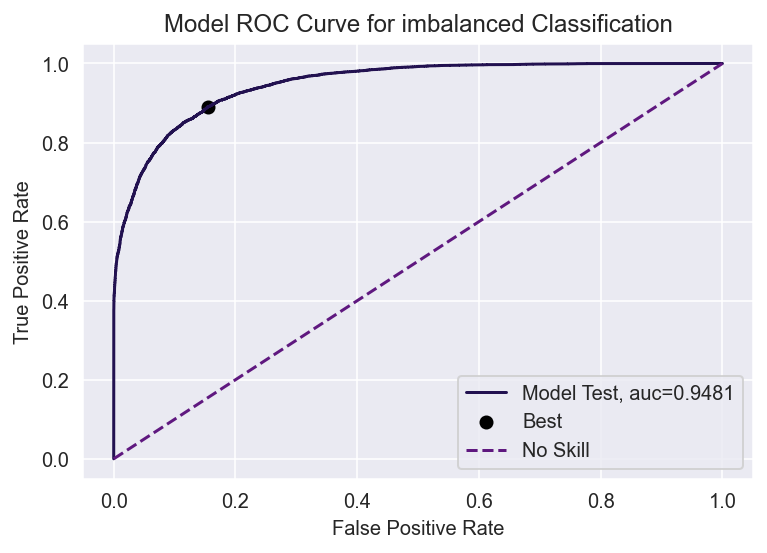

In [103]:
#Re-training RFC model : 

model=RandomForestClassifier(bootstrap= False,
                             max_depth= 15,
                             max_features= 'auto',
                             min_samples_leaf= 1,
                             min_samples_split= 6,
                             n_estimators= 144,
                             random_state=4,n_jobs=8)

training(model)

Best threshold=0.345163 , G-Mean=0.886
Overfitting:0.025033372046611158


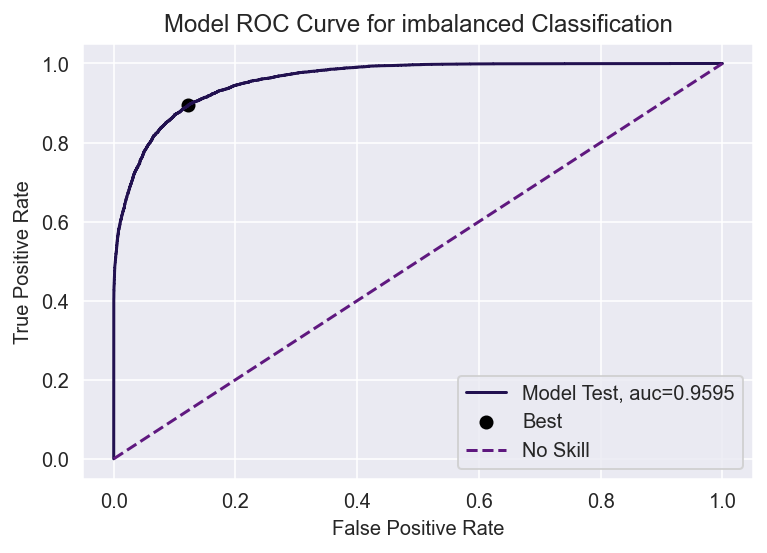

In [73]:
#Re-training LGBMC model : 

model=lgb.LGBMClassifier(colsample_bytree= 0.8685103809345779,
                         learning_rate= 0.1956891463671399,
                         max_depth= 59,
                         min_child_weight= 0.5877452861635482,
                         n_estimators= 245,
                         reg_alpha= 1.1,
                         reg_lambda= 0.115873344542883,
                         num_leaves=68,
                         objective='binary',
                         random_state=9,n_jobs=-1)

training(model)

[14:52:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best threshold=0.324968 , G-Mean=0.890
Overfitting:0.03375434214795947


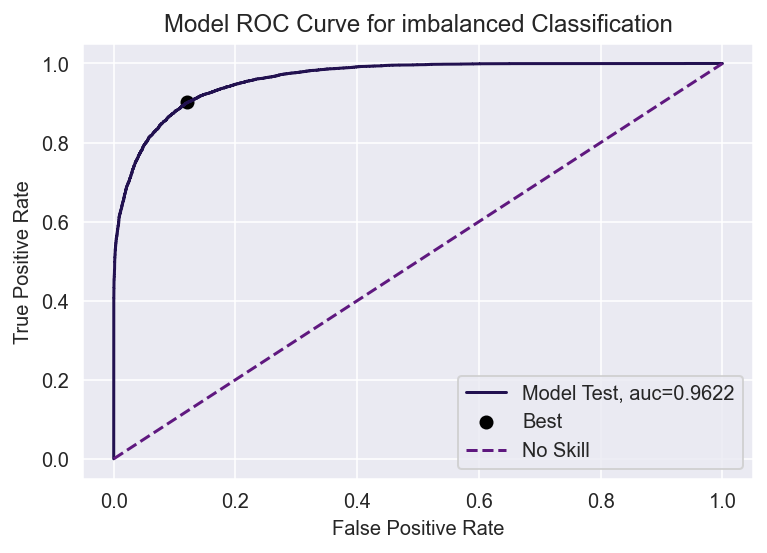

In [104]:
#Re-training XGBoost model :

model=xgb.XGBClassifier(colsample_bytree= 0.559293451675515,
                        gamma= 0.02541644459633352,
                        learning_rate= 0.09760106411878408,
                        max_depth= 15,
                        min_child_weight= 0.5677464514364309,
                        n_estimators= 184,
                        reg_alpha= 0.6175009121468831,
                        reg_lambda= 1.4576085991257932,
                        subsample= 0.6353451401562455,
                        random_state=8, tree_method='exact')

training(model)

We can see very similar behaviour between models performance, perhaps a higher overfitting value with XGBoost. So we decide to take LightGBM for this dataset as a good choice, due to its performance and also the computational time, which is significative smaller than with the other methods. We appreciate that the Best threshold for the model if found for values around 0.32 or 0.35. This is a logic result as we have an unbalanced dataset in a proportion of 32%. Now, let´s train our model modifying the threshold value (this is the same as resampling our dataset adding more observations of the minority class). As we can see, balancing the classes weights the threshold best value moves near 0.5 (that would be the perfect value for a perfect balanced dataset).

Best threshold=0.482596 , G-Mean=0.886
Overfitting:0.024986595133393075


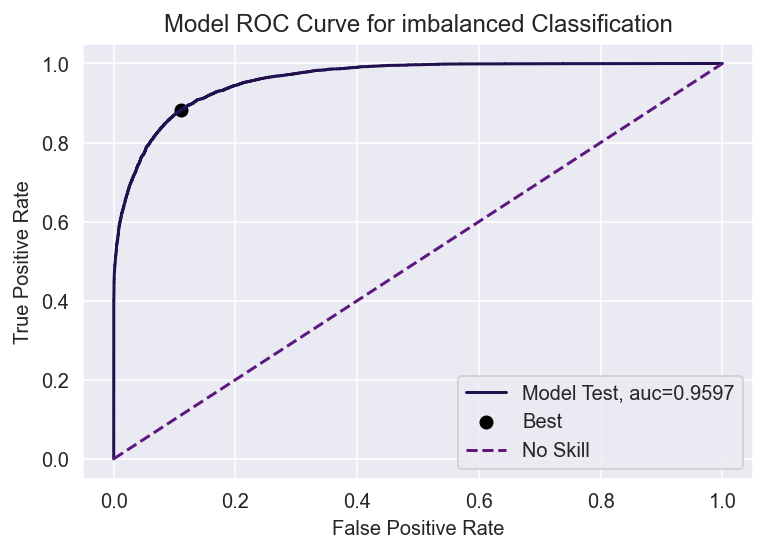

In [72]:
import lightgbm as lgb
model=lgb.LGBMClassifier(colsample_bytree= 0.8685103809345779,
                         learning_rate= 0.1956891463671399,
                         max_depth= 59,
                         min_child_weight= 0.5877452861635482,
                         n_estimators= 245,
                         reg_alpha= 1.1,
                         reg_lambda= 0.115873344542883,
                         num_leaves=68,
                         objective='binary',
                         class_weight='balanced',
                         random_state=9,n_jobs=-1)

training(model)

### Comparing results

In [75]:
#Now, comparing behaviour of the unbalanced and balanced models:

unbalanced=lgb.LGBMClassifier(colsample_bytree= 0.8685103809345779,
                         learning_rate= 0.1956891463671399,
                         max_depth= 59,
                         min_child_weight= 0.5877452861635482,
                         n_estimators= 245,
                         reg_alpha= 1.1,
                         reg_lambda= 0.115873344542883,
                         num_leaves=68,
                         objective='binary',
                         random_state=9,n_jobs=-1)

balanced=lgb.LGBMClassifier(colsample_bytree= 0.8685103809345779,
                         learning_rate= 0.1956891463671399,
                         max_depth= 59,
                         min_child_weight= 0.5877452861635482,
                         n_estimators= 245,
                         reg_alpha= 1.1,
                         reg_lambda= 0.115873344542883,
                         num_leaves=68,
                         objective='binary',
                         class_weight='balanced',
                         random_state=9,n_jobs=-1)


unbalanced.fit(data_train_std,target_train)
balanced.fit(data_train_std,target_train)
pred_unbalanced=unbalanced.predict(data_test_std)
pred_balanced=balanced.predict(data_test_std)

LGBMClassifier(colsample_bytree=0.8685103809345779,
               learning_rate=0.1956891463671399, max_depth=59,
               min_child_weight=0.5877452861635482, n_estimators=245,
               num_leaves=68, objective='binary', random_state=9, reg_alpha=1.1,
               reg_lambda=0.115873344542883)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8685103809345779,
               learning_rate=0.1956891463671399, max_depth=59,
               min_child_weight=0.5877452861635482, n_estimators=245,
               num_leaves=68, objective='binary', random_state=9, reg_alpha=1.1,
               reg_lambda=0.115873344542883)

In [78]:
from sklearn.metrics import classification_report

print(classification_report(target_test,pred_unbalanced, target_names=['No cancelled', 'Cancelled']))
print(classification_report(target_test,pred_balanced,target_names=['No cancelled', 'Cancelled']))

              precision    recall  f1-score   support

No cancelled       0.90      0.93      0.91     14822
   Cancelled       0.87      0.83      0.85      8925

    accuracy                           0.89     23747
   macro avg       0.89      0.88      0.88     23747
weighted avg       0.89      0.89      0.89     23747

              precision    recall  f1-score   support

No cancelled       0.92      0.90      0.91     14822
   Cancelled       0.83      0.88      0.85      8925

    accuracy                           0.89     23747
   macro avg       0.88      0.89      0.88     23747
weighted avg       0.89      0.89      0.89     23747



Conclusion: Both models seem to have very similar metrics in performance, but the second one (with a balanced threshold) shows a better behaviour when predicting real 'cancelled' cases (higher recall). This is a better option, as we want to prevent as much real cancellations as possible. 

#### SOME IMPORTANT NOTES IN THIS PROJECT

As we have explained above, there is an important concept to take into account while we are developing preprocessing with our data. This concept is Data Leakage. We can find two main types of Leakage in our data: Train-Test contamination and Target Leakage. 

The first one takes place when we develop a preprocessing step with all data (without split into train and test sets) and we use all data for calculating the values for some feature imputation (for example, a mean or mode value). The second one occurs when we have features in our dataset with information that is known some time after we make a prediction, that is, it is something similar to "future" information or information that we don´t know at the time of making a prediction.

Both cases of leakage have to be avoided as we can develop a model that performs worse than it seems to during the training. Leakage increases the performance metrics of the models, because we are adding extra information that we know from the test set or from the target. We can think that our model performs quite good, but we realize that it has nothing to do with the real performance when we predict unseen data. Target leakage is really harmful, as it may seem that the model works even perfectly. Let´s take a look with this project taking into account two features that we have removed during preprocessing steps: 'reservation_status_date' and 'reservation_status'.

For this demostrative purposes, we will use our custom function "sgdcmodel" which performs SGD Algorithm over our data and outputs the ROC_AUC area as metric.

In [16]:
#Training the model with 'reservation_status_date' and 'reservation_status': Data_train_std contains both features.

sgdcmodel(data_train_std, data_test_std, target_train, target_test)

1.0

In [17]:
#Training the model without 'reservation_status_date' and 'reservation_status': Both features have been removed from
#Data_train_std in this case:

sgdcmodel(data_train_std, data_test_std, target_train, target_test)

0.8136651891899656

Here it is!! Taking into account both features the models seems to perform perfect, but if we remove both from the dataset the performance drops near 20%. The reason is that there is a perfect linear correlation between target and these features, as the information that contains both is known after the event of target takes place.

In [13]:
#Checking the high correlation between target and these features:

dicty={'Check-Out':0, 'Canceled':1, 'No-Show':2 }
data['reservation_status']=data['reservation_status'].map(dicty)
data[['is_canceled', 'reservation_status']].corr()

,is_canceled,reservation_status
is_canceled,1.000,0.981
reservation_status,0.981,1.000
